## Table of Contents
<br>
<ol> 
    <li style="font-weight: bold;">
    <h2><a href='#1' style="text-decoration : none; color: #000000;">Vulnerable/Control Set 30:70 </a></h2>
    <ul> <a href='#1.1' style="text-decoration : none; color: #000000;"> 1.1 Loading Data </a></ul>
    <ul> <a href='#1.2' style="text-decoration : none; color: #000000;"> 1.2  70: 30 Train Test split </a>
    <ol> <a href='#1.2.1' style="text-decoration : none; color: #000000;">1.2.1 Results </a></ol></ul>
    <ul> <a href='#1.3' style="text-decoration : none; color: #000000;"> 1.3  80: 20 Train Test split </a>
    <ol> <a href='#1.3.1' style="text-decoration : none; color: #000000;">1.3.1 Results </a></ol></ul></li>
</ol>
<ol start ='2'>
    <li style="font-weight: bold;">
    <h2><a href='#2' style="text-decoration : none; color: #000000;">Vulnerable/Control Set 50:50 </a></h2>
    <ul> <a href='#2.1' style="text-decoration : none; color: #000000;"> 2.1 Loading Data </a></ul>
    <ul> <a href='#2.2' style="text-decoration : none; color: #000000;"> 2.2  70: 30 Train Test split </a>
    <ol> <a href='#2.2.1' style="text-decoration : none; color: #000000;">2.2.1 Results </a></ol></ul>
    <ul> <a href='#2.3' style="text-decoration : none; color: #000000;"> 2.3  80: 20 Train Test split </a>
    <ol> <a href='#2.3.1' style="text-decoration : none; color: #000000;">2.3.1 Results </a></ol></ul></li>
</ol>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import confusion_matrix as CM,accuracy_score,auc,roc_curve
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler,binarize
from pandas_ml import ConfusionMatrix

from IPython.display import display,clear_output,HTML

Using TensorFlow backend.


### <a id='1' style="text-decoration : none; color: #000000;"> 1 Vulnerable/Control 30:70 </a>

#### <a id='1.1' style="text-decoration : none; color: #000000;"> 1.1 Loading Data </a>

In [2]:
df=pd.read_csv('Final_feature_set-Copy1.csv',index_col=['Unnamed: 0'])
df.fillna(value=0,inplace=True)

print("Count of Malicious/Non-Malicious users:")
display(df.Malicious.value_counts())

print("\nNumber of Users with Age less than equal to 0:")
display(df[df.Age<=0]['Malicious'].value_counts())

print("After eliminating users whose predicted age is less than 0 and randomly selecting from control set users:")
df=df[df.Age>0]
nm=df[df.Malicious==0]
m=df[df.Malicious==1]

df=m.append(nm.sample(frac=((len(m)/0.3)*0.7)/len(nm),random_state=10))

df.Malicious.value_counts()

Count of Malicious/Non-Malicious users:


0    7059
1    1905
Name: Malicious, dtype: int64


Number of Users with Age less than equal to 0:


0    3
1    2
Name: Malicious, dtype: int64

After eliminating users whose predicted age is less than 0 and randomly selecting from control set users:


0    4440
1    1903
Name: Malicious, dtype: int64

In [3]:
df2=df.copy(deep=True)
df2.drop(['User_Id','User_Name_x','Created_At','Language'],axis=1,inplace=True)
df2.set_index(['User_Screen_Name'],inplace=True,drop=True)
df2.Gender=df2.Gender.apply(lambda x: 1 if x=='F' else 0)
df2.drop(['Statuses_Count','User_Name_y'],axis=1,inplace=True)
df2=df2.sample(frac=1,random_state=0)
df2.head()

,Followers_Count,Friends_Count,Listed_Count,Favorites_Count,Number of Tweets,Avg Number of Mentions,Average Number of Links,Average Number of Words,Acc_Age_Month,Malicious,Age,Gender
User_Screen_Name,,,,,,,,,,,,
SmashChappy,38,59,1,1171,640,0.176563,0.503125,11.253125,45.570817,1,21.630452,0
leahguestx,1230,628,3,8820,2028,0.431460,0.148915,8.052268,79.115251,1,19.847254,1
Rooney_Mugo,186,523,2,896,75,0.280000,0.146667,10.920000,41.393339,0,21.672530,1
nimadara,55,1,0,2149,21,0.857143,0.857143,7.095238,44.915104,0,33.854566,1
Reef_gladstone,34,77,1,0,959,0.004171,0.967675,14.434828,43.210114,0,42.649813,0


In [4]:
### Function get_params takes as input a grid search model and prints out the best parameters for the model and 
### prints the best accuracy of the model
def get_params(grid,model_name=''):
    print("Best Parameters are :")
    display(pd.DataFrame.from_dict(grid.best_params_, orient='index').reset_index().transpose())

### The function takes as input the model, X and Y data to generate the confusion matrix  
def get_cm(model,a,b):
    y_pred=model.predict(a)
    cm=ConfusionMatrix(b,y_pred)
    display(cm)
    return cm
 
### The get accuracy plot takes as input a dataframe and a string for the title of the plot and displays a plot
### The function is primarily for plotting of accuracies for various classifiers for the same split.
def get_accuracy_plot(data,title=''):
    plt.figure(figsize=(12,8))
    plt.plot(data['accuracy'].values, '--o')
    plt.ylabel('Accuracy', fontsize=20)
    plt.xlabel('Classifier', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.xlim([0, 9])
    plt.title(title,size=18,y=1.05)
    plt.xticks(np.arange(10),data.index.get_values(),rotation=90)
    plt.legend(loc='upper right', fontsize=18)
    plt.show()

### Function grid takes as input an estimator, X_train,Y_Train,X_test and Y_test and a string represetning the name of the model
### We perform StratifiedKFold cross validation and grid search to hypertune the parameters of the model     
def grid_acc(kernel,params,x,y,x_test,y_test,model_name=''):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    grid_search=GridSearchCV(estimator=kernel,param_grid=parameters,scoring='accuracy',cv=kfold,n_jobs=-1)
    grid_search.fit(x,y)
    get_params(grid_search,model_name)
    acc_train=accuracy_score(y,grid_search.predict(x))
    print("Accuracy of the ",model_name," model for the training data is:",acc_train)
    print("\nConfusion Matrix for Training data is:")
    cm_train=get_cm(grid_search,x,y)
    acc_test=accuracy_score(y_test,grid_search.predict(x_test))
    print("Accuracy of the ",model_name," model for test data is:",acc_test)
    print("\nConfusion Matrix for test data is:")
    cm_test=get_cm(grid_search,x_test,y_test)
    return grid_search,cm_train,cm_test,acc_train,acc_test    

### Plot roc curve
def get_roc_curve(model,x_test,y_test):
    prob=model.predict_proba(x_test)
    preds=prob[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc =auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(threshold, index = i)})
    threshold=roc.ix[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
    print("Optimal Threshold is",threshold)
    y_pred_class=binarize(preds.reshape(1,-1),threshold)[0]
    accuracy=accuracy_score(y_test,y_pred_class)
    print("Accuracy on test data is:",accuracy)
    cm=ConfusionMatrix(y_test,y_pred_class)
    display(cm)
    return cm,accuracy,threshold,roc_auc

def get_roc_curve_deep_learning(model,x_test,y_test):
    prob=model.predict_proba(x_test)
    preds=prob
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc =auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(threshold, index = i)})
    threshold=roc.ix[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
    print("Optimal Threshold is",threshold)
    y_pred_class=binarize(preds.reshape(1,-1),threshold)[0]
    accuracy=accuracy_score(y_test,y_pred_class)
    print("Accuracy of Logistic Model on training data is:",accuracy)
    cm=ConfusionMatrix(y_test,y_pred_class)
    display(cm)
    return cm,accuracy,threshold,roc_auc

#### Graphs

In [5]:
df3=df2.copy(deep=True)
df3.Malicious=df3.Malicious.apply(lambda x: 'Malicious' if x==1 else 'Non-Malicious')
df3.Gender=df3.Gender.apply(lambda x: 'Female' if x==1 else 'Male')

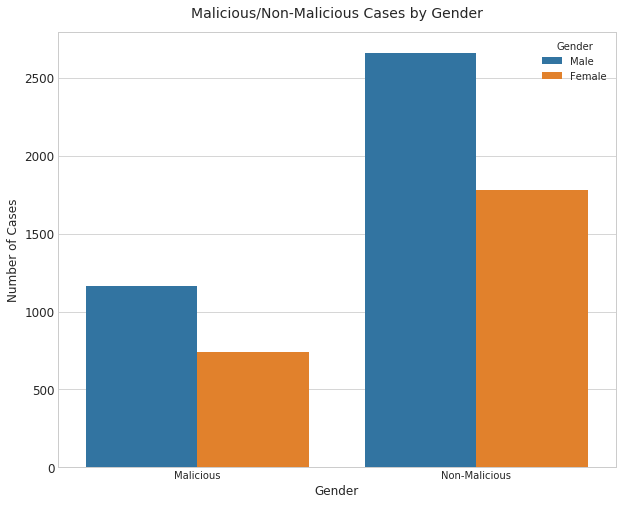

In [6]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,8))
sns.countplot(x='Malicious',data=df3,hue='Gender')
plt.yticks(size=12)
plt.xlabel('Gender',size=12)
plt.ylabel('Number of Cases',size=12)
plt.title('Malicious/Non-Malicious Cases by Gender',size=14,y=1.02)
plt.sa
plt.show()

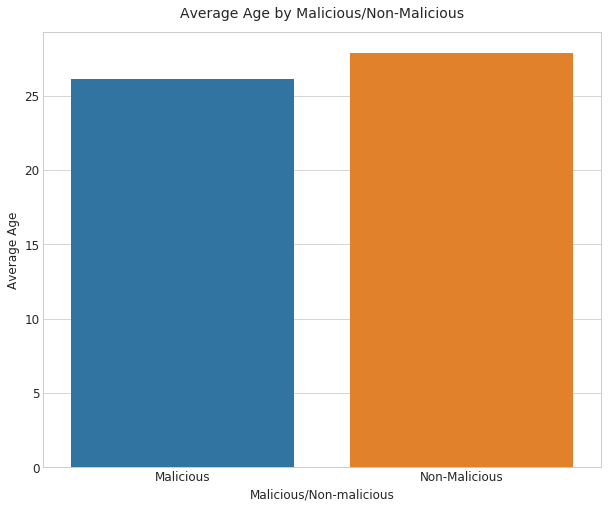

In [7]:
avg_age=df3.groupby('Malicious')['Age'].mean()
avg_age=pd.DataFrame(avg_age).reset_index()
sns.set_style('whitegrid')
plt.figure(figsize=(10,8))
sns.barplot(x=avg_age['Malicious'],y=avg_age['Age'])
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Malicious/Non-malicious',size=12)
plt.ylabel('Average Age',size=12)
plt.title('Average Age by Malicious/Non-Malicious',size=14,y=1.02)
plt.show()

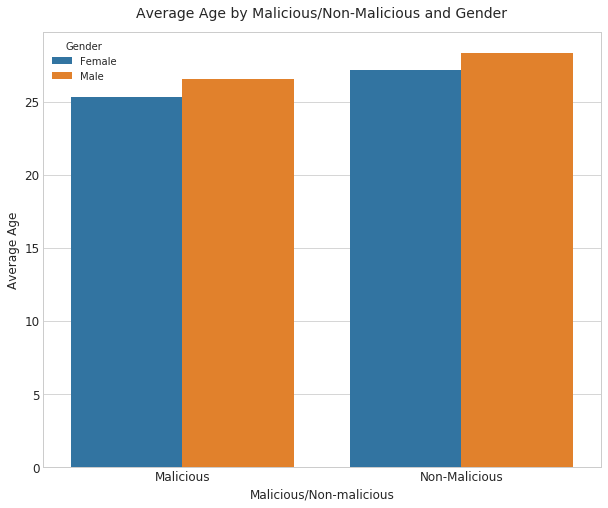

In [8]:
avg_age=df3.groupby(['Malicious','Gender'])['Age'].mean()
avg_age=pd.DataFrame(avg_age).reset_index()

sns.set_style('whitegrid')
plt.figure(figsize=(10,8))
sns.barplot(x=avg_age['Malicious'],y=avg_age['Age'],hue=avg_age['Gender'])
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Malicious/Non-malicious',size=12)
plt.ylabel('Average Age',size=12)
plt.title('Average Age by Malicious/Non-Malicious and Gender',size=14,y=1.02)
plt.show()

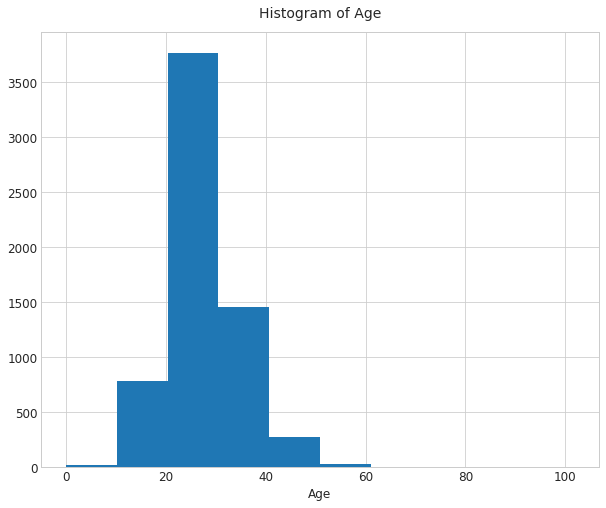

In [9]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,8))
plt.hist(df3['Age'])
plt.xticks(size=12)
plt.xlabel('Age',size=12)
plt.yticks(size=12)
plt.title('Histogram of Age',size=14,y=1.02)
plt.show()

#### <a id='1.2' style="text-decoration : none; color: #000000;"> 1.2  70: 30 Train Test split </a>

In [10]:
Y=df2.Malicious.values
X=df2.iloc[:,df2.columns!='Malicious']
columns=X.columns.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 70:30")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.3)

The train/test split ratio is 70:30


In [11]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

##### 1.2.1 KNN

In [12]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


,0,1,2,3,4
index,algorithm,leaf_size,metric,n_neighbors,weights
0,auto,2,manhattan,30,distance


Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       3110     0     3110
True           0  1330     1330
__all__     3110  1330     4440

Accuracy of the  KNN  model for test data is: 0.815028901734104

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1301    29     1330
True         323   250      573
__all__     1624   279     1903

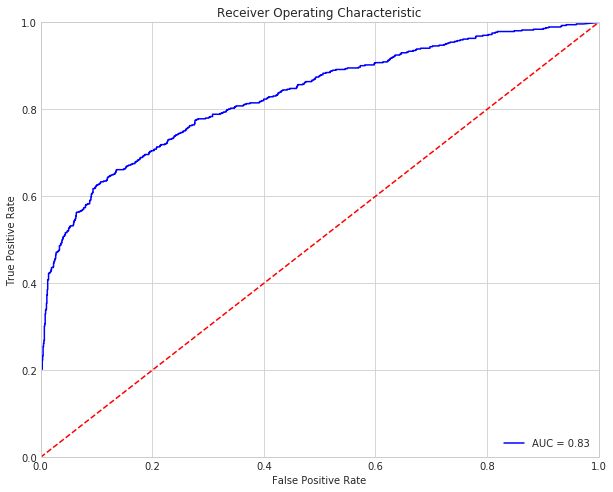

Optimal Threshold is 0.23752179060165676
Accuracy on test data is: 0.7461902259590121


Predicted  False  True  __all__
Actual                         
False        992   338     1330
True         145   428      573
__all__     1137   766     1903

In [13]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [14]:
table_80_50_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.2.2 Logistic

In [15]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[10000],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


,0,1,2,3,4,5,6,7,8
index,C,dual,fit_intercept,intercept_scaling,max_iter,multi_class,penalty,solver,tol
0,0.5,False,True,0.7,10000,multinomial,l2,sag,0.001


Accuracy of the  Logistic  model for the training data is: 0.7799549549549549

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       2919   191     3110
True         786   544     1330
__all__     3705   735     4440

Accuracy of the  Logistic  model for test data is: 0.7940094587493431

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1258    72     1330
True         320   253      573
__all__     1578   325     1903

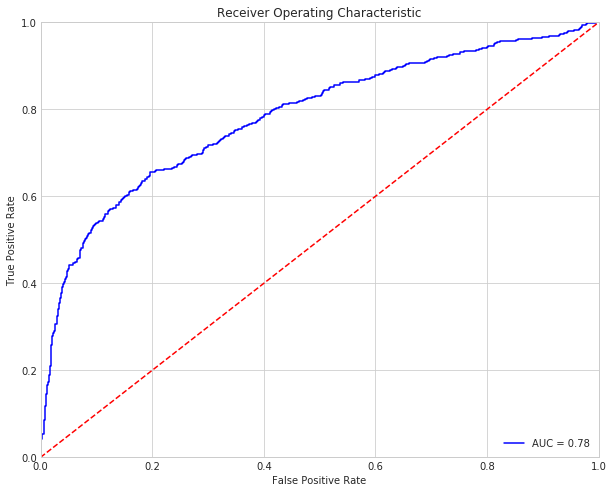

Optimal Threshold is 0.3775930883035837
Accuracy on test data is: 0.7078297425118234


Predicted  False  True  __all__
Actual                         
False        942   388     1330
True         168   405      573
__all__     1110   793     1903

In [16]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [17]:
table_80_50_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.2.3 Random Forest Classifier

In [18]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[200,500],criterion=['gini','entropy'],max_depth=[10,5],min_samples_split=[10,5],
                  min_samples_leaf=[10,5],min_weight_fraction_leaf=[0.1,0.3], max_features=['auto'],
                  max_leaf_nodes=[10,5],min_impurity_decrease=[0.1,0.3],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


,0,1,2,3,4,5,6,7,8,9,10,11
index,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,oob_score,random_state,verbose
0,gini,10,auto,10,0.1,10,10,0.1,200,False,0,0


Accuracy of the  Random Forest Trees  model for the training data is: 0.7004504504504504

Confusion Matrix for Training data is:


Predicted     0  1  __all__
Actual                     
0          3110  0     3110
1          1330  0     1330
__all__    4440  0     4440

Accuracy of the  Random Forest Trees  model for test data is: 0.6988964792433

Confusion Matrix for test data is:


Predicted     0  1  __all__
Actual                     
0          1330  0     1330
1           573  0      573
__all__    1903  0     1903

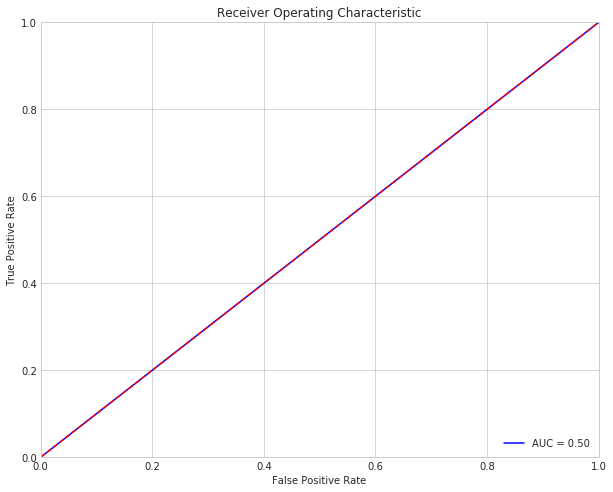

Optimal Threshold is 1.2993006756756758
Accuracy on test data is: 0.6988964792433


Predicted   0.0  1.0  __all__
Actual                       
0.0        1330    0     1330
1.0         573    0      573
__all__    1903    0     1903

In [19]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [20]:
table_80_50_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

3110
0
0
3110
1330
0
0
1330
1.0
0.0
0.0
1.0
1330
0
0
1330
573
0
0
573
1.0
0.0
0.0
1.0
1330
0
0
1330
573
0
0
573
1.0
0.0
0.0
1.0


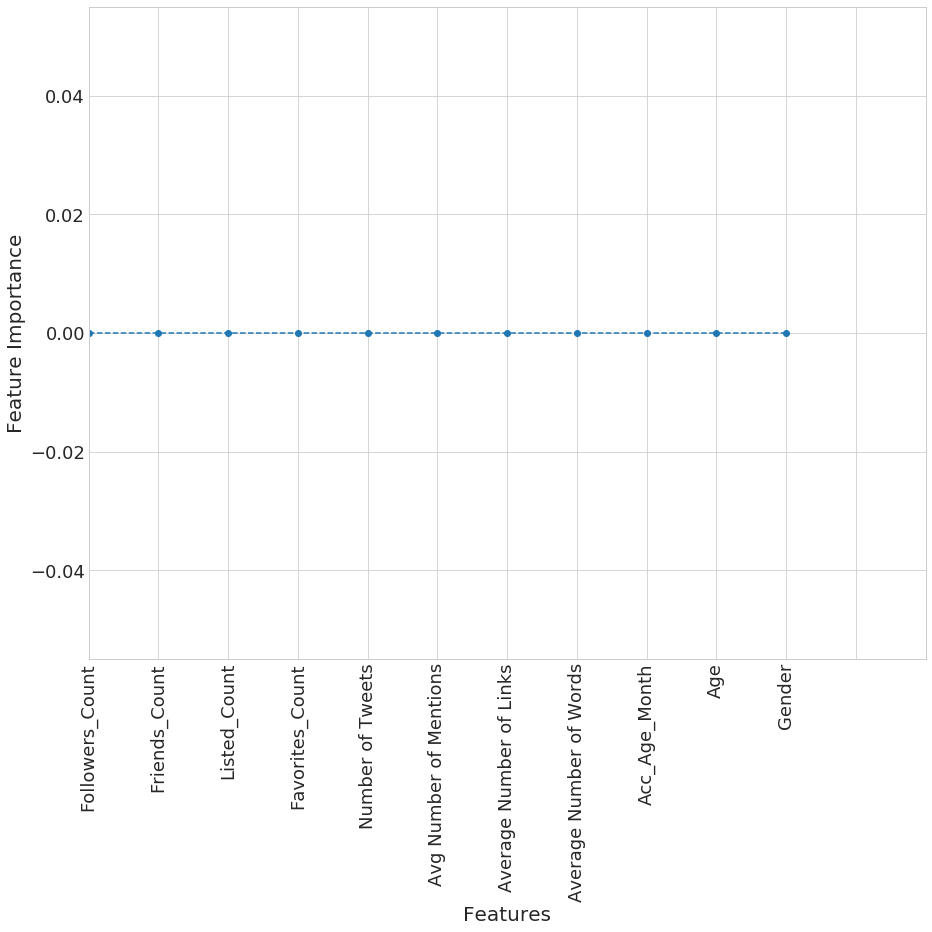

In [21]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [22]:
pd.Series(rf.feature_importances_,index=columns)

Followers_Count            0.0
Friends_Count              0.0
Listed_Count               0.0
Favorites_Count            0.0
Number of Tweets           0.0
Avg Number of Mentions     0.0
Average Number of Links    0.0
Average Number of Words    0.0
Acc_Age_Month              0.0
Age                        0.0
Gender                     0.0
dtype: float64

##### 1.2.4 AdaBoost Classifier

In [23]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


,0,1,2,3
index,algorithm,learning_rate,n_estimators,random_state
0,SAMME,1,400,0


Accuracy of the  AdaBoostClassifier  model for the training data is: 0.8387387387387387

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       2972   138     3110
True         578   752     1330
__all__     3550   890     4440

Accuracy of the  AdaBoostClassifier  model for test data is: 0.8407777193904361

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1269    61     1330
True         242   331      573
__all__     1511   392     1903

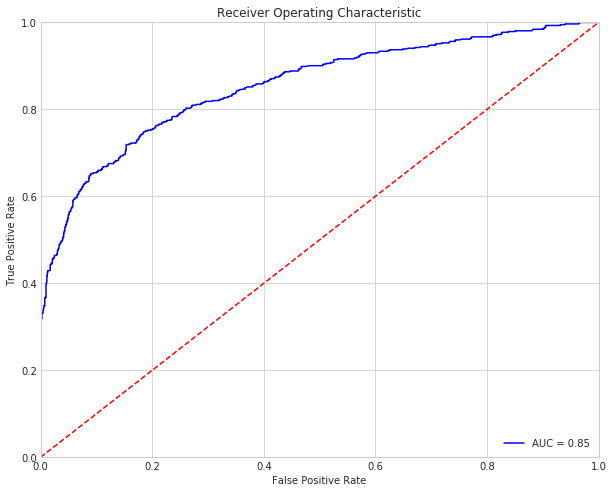

Optimal Threshold is 0.49382588503271485
Accuracy on test data is: 0.7735155018392013


Predicted  False  True  __all__
Actual                         
False       1029   301     1330
True         130   443      573
__all__     1159   744     1903

In [24]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [25]:
table_80_50_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

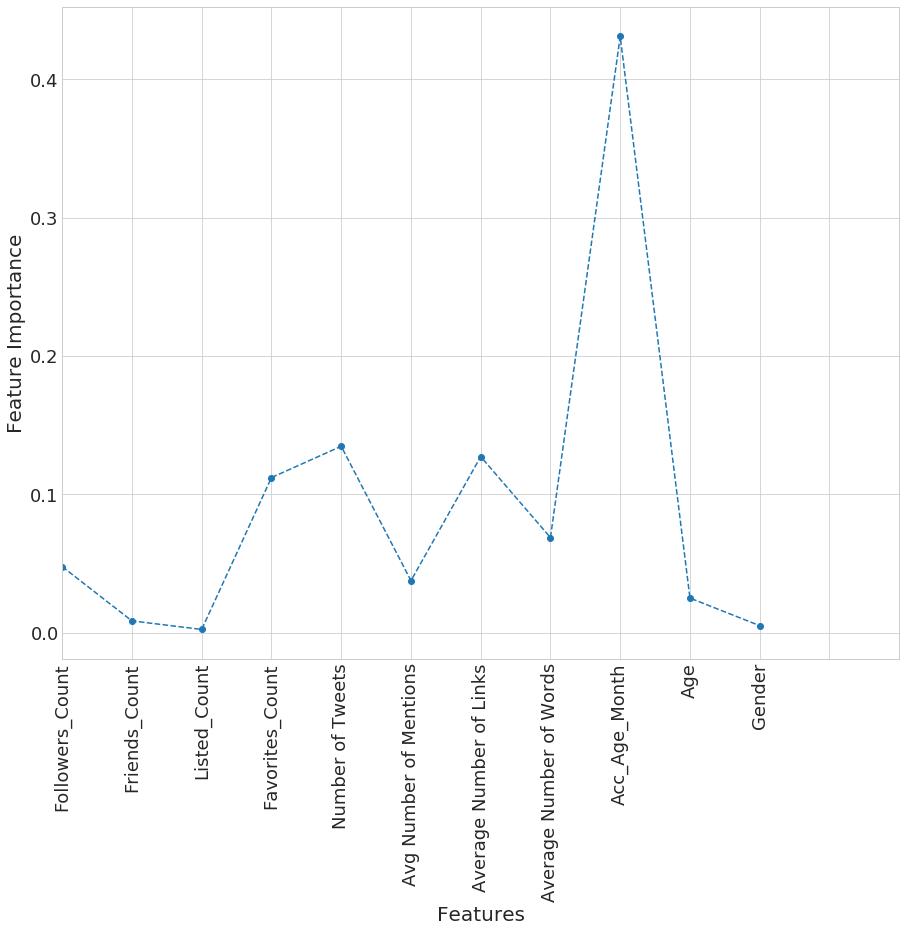

In [26]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0,12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [27]:
pd.Series(ada.feature_importances_,index=columns)

Followers_Count            0.047734
Friends_Count              0.008525
Listed_Count               0.002364
Favorites_Count            0.112086
Number of Tweets           0.134712
Avg Number of Mentions     0.037597
Average Number of Links    0.127243
Average Number of Words    0.068753
Acc_Age_Month              0.430876
Age                        0.025023
Gender                     0.005088
dtype: float64

##### 1.2.5 GradientBoosting Classifier

In [28]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.1,deviance,15,0.2,100,0,0.7


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.8488738738738739

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       2986   124     3110
True         547   783     1330
__all__     3533   907     4440

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.8486600105097215

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1271    59     1330
True         229   344      573
__all__     1500   403     1903

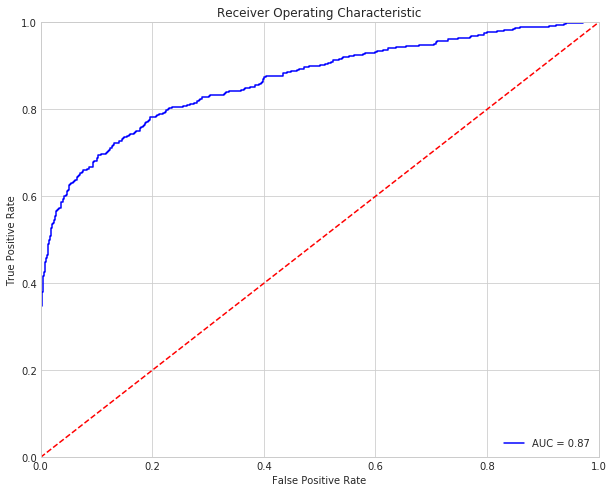

Optimal Threshold is 0.23215951832962162
Accuracy on test data is: 0.7877036258539148


Predicted  False  True  __all__
Actual                         
False       1048   282     1330
True         122   451      573
__all__     1170   733     1903

In [29]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [30]:
table_80_50_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

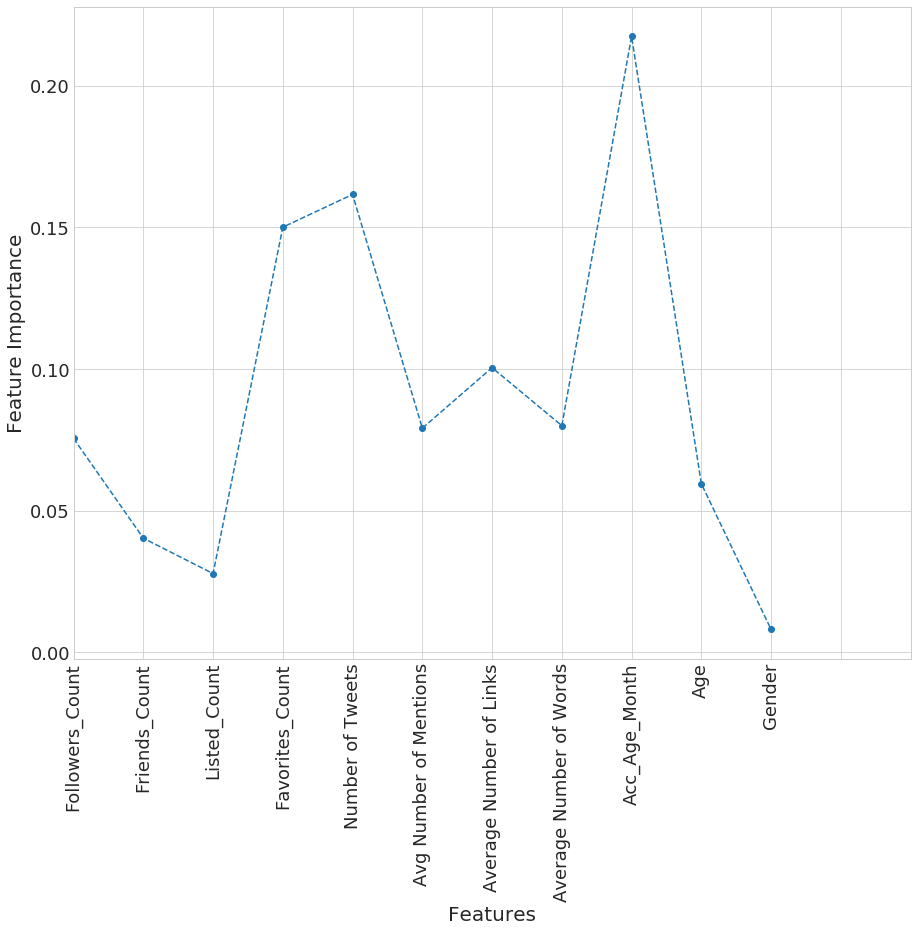

In [31]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [32]:
pd.Series(gbc.feature_importances_,index=columns)

Followers_Count            0.075506
Friends_Count              0.040279
Listed_Count               0.027773
Favorites_Count            0.150107
Number of Tweets           0.161672
Avg Number of Mentions     0.079116
Average Number of Links    0.100497
Average Number of Words    0.080014
Acc_Age_Month              0.217469
Age                        0.059506
Gender                     0.008060
dtype: float64

##### 1.2.6 ExtraTree Classifier

In [33]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,max_depth,max_features,min_impurity_decrease,min_samples_leaf,min_samples_split,random_state,splitter
0,entropy,10,auto,0.001,3,2,0,best


Accuracy of the  Extra Decision Tree  model for the training data is: 0.8434684684684685

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       2997   113     3110
True         582   748     1330
__all__     3579   861     4440

Accuracy of the  Extra Decision Tree  model for test data is: 0.8255386232264845

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1267    63     1330
True         269   304      573
__all__     1536   367     1903

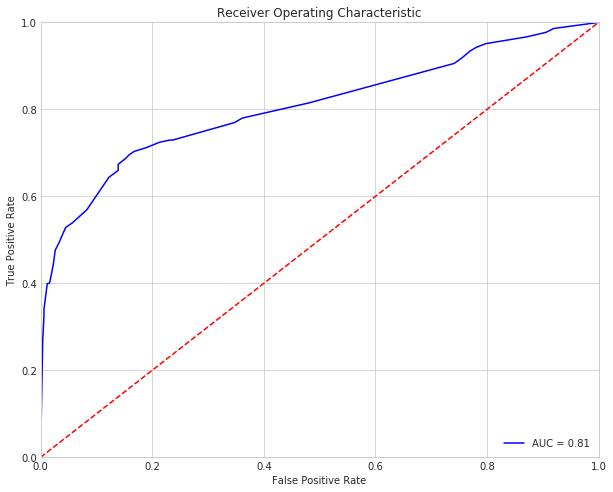

Optimal Threshold is 0.18181818181818182
Accuracy on test data is: 0.7566999474513926


Predicted  False  True  __all__
Actual                         
False       1022   308     1330
True         155   418      573
__all__     1177   726     1903

In [34]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [35]:
table_80_50_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

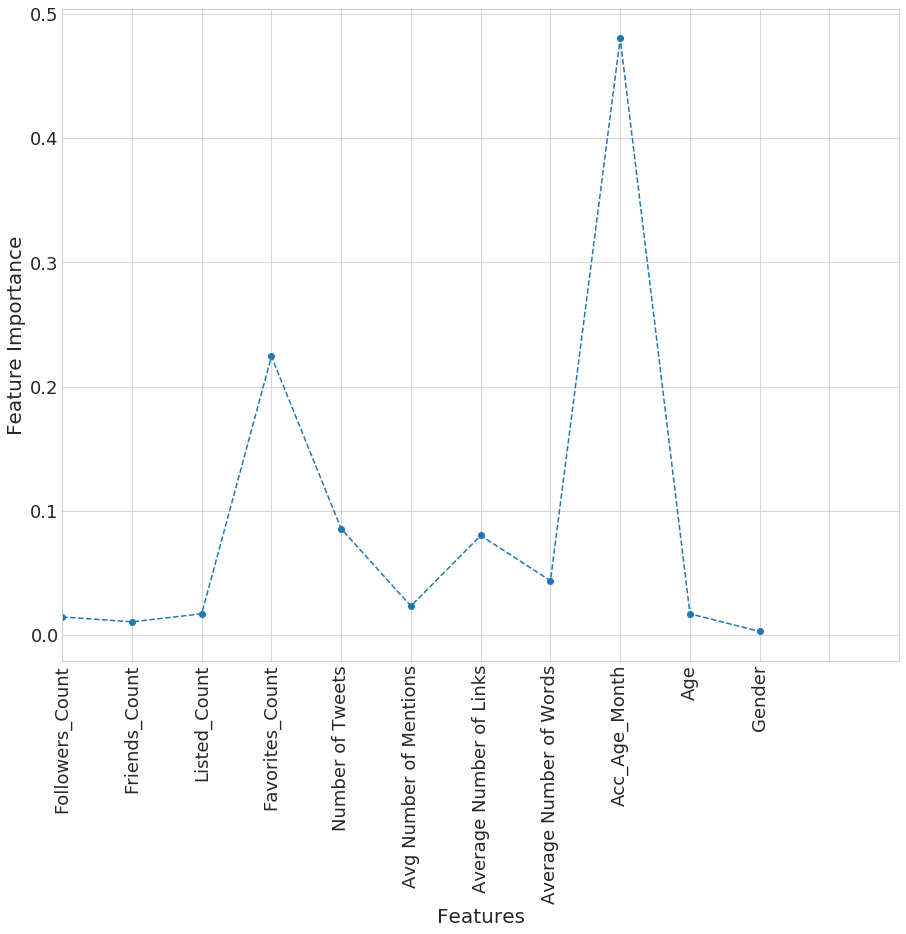

In [36]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [37]:
pd.Series(ext.feature_importances_,index=columns)

Followers_Count            0.014629
Friends_Count              0.010684
Listed_Count               0.017175
Favorites_Count            0.224275
Number of Tweets           0.085598
Avg Number of Mentions     0.023371
Average Number of Links    0.080202
Average Number of Words    0.043719
Acc_Age_Month              0.480231
Age                        0.017142
Gender                     0.002974
dtype: float64

##### 1.2.7 Bagging Classifier

In [38]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[300,500,100], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


,0,1,2,3,4,5,6
index,bootstrap,bootstrap_features,max_features,max_samples,n_estimators,oob_score,random_state
0,True,True,0.6,0.4,500,True,0


Accuracy of the  Bagging  model for the training data is: 0.9459459459459459

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       3110     0     3110
True         240  1090     1330
__all__     3350  1090     4440

Accuracy of the  Bagging  model for test data is: 0.8423541776142932

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       1308    22     1330
True         278   295      573
__all__     1586   317     1903

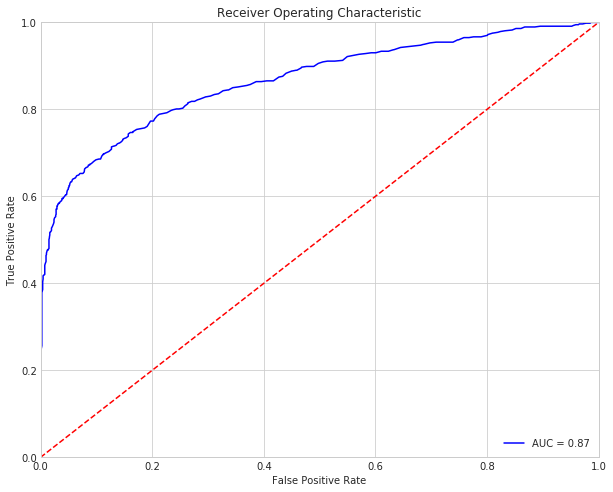

Optimal Threshold is 0.296
Accuracy on test data is: 0.789280084077772


Predicted  False  True  __all__
Actual                         
False       1052   278     1330
True         123   450      573
__all__     1175   728     1903

In [39]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [40]:
table_80_50_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.2.8 Voting Classifier

In [41]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The training accuracy is : 0.9227477477477477


/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Predicted  False  True  __all__
Actual                         
False       3104     6     3110
True         337   993     1330
__all__     3441   999     4440

The test accuracy is: 0.8339464004203888


Predicted  False  True  __all__
Actual                         
False       1286    44     1330
True         272   301      573
__all__     1558   345     1903

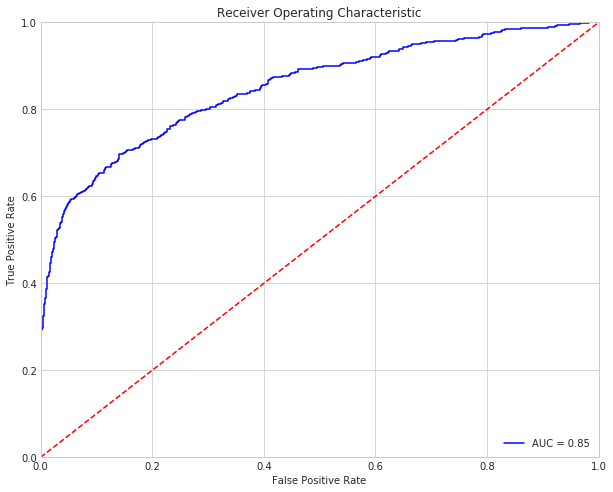

Optimal Threshold is 0.31602585758386653
Accuracy on test data is: 0.7630057803468208


Predicted  False  True  __all__
Actual                         
False       1015   315     1330
True         136   437      573
__all__     1151   752     1903

In [42]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [43]:
table_80_50_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.2.9 Deep Learning

In [44]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=11))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.8826576575502619


Predicted  False  True  __all__
Actual                         
False       3013    97     3110
True         424   906     1330
__all__     3437  1003     4440

The accuracy of the model on test data is: 0.8192327903310562


Predicted  False  True  __all__
Actual                         
False       1231    99     1330
True         245   328      573
__all__     1476   427     1903

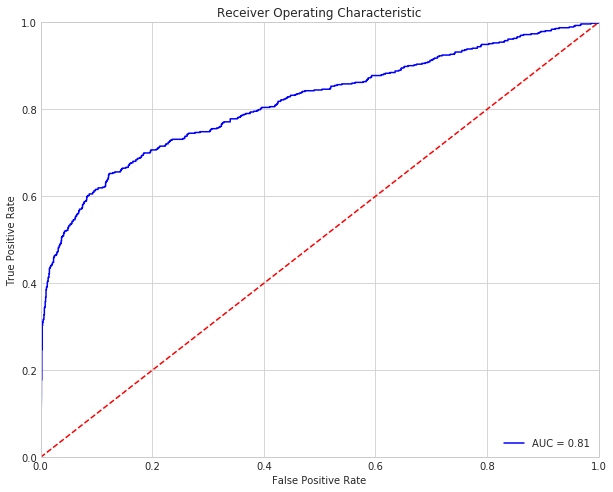

Optimal Threshold is 0.24095507
Accuracy of Logistic Model on training data is: 0.7383079348397268


Predicted  False  True  __all__
Actual                         
False        982   348     1330
True         150   423      573
__all__     1132   771     1903

In [45]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [46]:
table_80_50_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.2.10 Deep Learning with Grid Search

In [47]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=11))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   48.2s finished


The accuracy of the model on training data is: 0.8121621621621622


Predicted  False  True  __all__
Actual                         
False       3000   110     3110
True         724   606     1330
__all__     3724   716     4440

The accuracy of the model on test data is: 0.813977929584866


Predicted  False  True  __all__
Actual                         
False       1294    36     1330
True         318   255      573
__all__     1612   291     1903

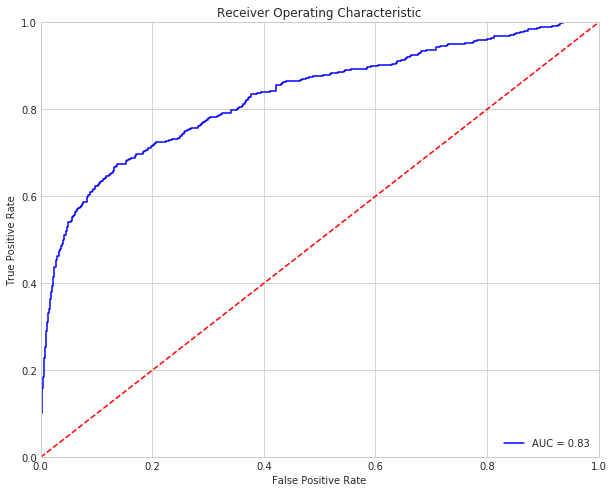

Optimal Threshold is 0.16952015
Accuracy on test data is: 0.744088281660536


Predicted  False  True  __all__
Actual                         
False        990   340     1330
True         147   426      573
__all__     1137   766     1903

In [48]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [49]:
table_80_50_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### <a id='#1.2.1' style="text-decoration : none; color: #000000;">1.2.1 Results </a>

In [50]:
table_80_50_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)
table_80_50_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_50_train)

print("Comparision Table for Test Accuracies:")
display(table_80_50_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_50_test_roc)

Comparision Table for Training Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,1.000000,1330.000000,3110.000000,0.000000,0.000000,0.000000,0.000000
LogisticRegression,0.779955,544.000000,2919.000000,191.000000,786.000000,0.061415,0.590977
RandomForestClassifier,0.700450,2178.400901,931.599099,931.599099,398.400901,0.700450,0.299550
AdaBoostClassifier,0.838739,752.000000,2972.000000,138.000000,578.000000,0.044373,0.434586
GradientBoostingClassifier,0.848874,783.000000,2986.000000,124.000000,547.000000,0.039871,0.411278
ExtraTreeClassifier,0.843468,748.000000,2997.000000,113.000000,582.000000,0.036334,0.437594
BaggingClassifier,0.945946,1090.000000,3110.000000,0.000000,240.000000,0.000000,0.180451
VotingClassifier,0.922748,993.000000,3104.000000,6.000000,337.000000,0.001929,0.253383
Neural Network-1,0.882658,906.000000,3013.000000,97.000000,424.000000,0.031190,0.318797


Comparision Table for Test Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.815029,250.000000,1301.000000,29.000000,323.000000,0.021805,0.563700
LogisticRegression,0.794009,253.000000,1258.000000,72.000000,320.000000,0.054135,0.558464
RandomForestClassifier,0.698896,929.532317,400.467683,400.467683,172.532317,0.698896,0.301104
AdaBoostClassifier,0.840778,331.000000,1269.000000,61.000000,242.000000,0.045865,0.422339
GradientBoostingClassifier,0.848660,344.000000,1271.000000,59.000000,229.000000,0.044361,0.399651
ExtraTreeClassifier,0.825539,304.000000,1267.000000,63.000000,269.000000,0.047368,0.469459
BaggingClassifier,0.842354,295.000000,1308.000000,22.000000,278.000000,0.016541,0.485166
VotingClassifier,0.833946,301.000000,1286.000000,44.000000,272.000000,0.033083,0.474695
Neural Network-1,0.819233,328.000000,1231.000000,99.000000,245.000000,0.074436,0.427574


Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


,accuracy,TP,TN,FP,FN,FPR,FNR,threshold,auc
index,,,,,,,,,
KNeighborsClassifier,0.746190,428.000000,992.000000,338.000000,145.000000,0.254135,0.253054,0.237522,0.831016
LogisticRegression,0.707830,405.000000,942.000000,388.000000,168.000000,0.291729,0.293194,0.377593,0.783503
RandomForestClassifier,0.698896,929.532317,400.467683,400.467683,172.532317,0.698896,0.301104,1.299301,0.500000
AdaBoostClassifier,0.773516,443.000000,1029.000000,301.000000,130.000000,0.226316,0.226876,0.493826,0.854080
GradientBoostingClassifier,0.787704,451.000000,1048.000000,282.000000,122.000000,0.212030,0.212914,0.232160,0.866281
ExtraTreeClassifier,0.756700,418.000000,1022.000000,308.000000,155.000000,0.231579,0.270506,0.181818,0.806862
BaggingClassifier,0.789280,450.000000,1052.000000,278.000000,123.000000,0.209023,0.214660,0.296000,0.865915
VotingClassifier,0.763006,437.000000,1015.000000,315.000000,136.000000,0.236842,0.237347,0.316026,0.850057
Neural Network-1,0.738308,423.000000,982.000000,348.000000,150.000000,0.261654,0.261780,0.240955,0.814565


###  <a id='1.3' style="text-decoration : none; color: #000000;"> 1.3  80:20 Train Test split </a>

In [51]:
Y=df2.Malicious.values
X=df2.iloc[:,df2.columns!='Malicious']
columns=X.columns.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [52]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

##### 1.3.1 KNN

In [53]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


,0,1,2,3,4
index,algorithm,leaf_size,metric,n_neighbors,weights
0,auto,2,manhattan,20,distance


Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       3557     0     3557
True           0  1517     1517
__all__     3557  1517     5074

Accuracy of the  KNN  model for test data is: 0.8148148148148148

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        857    26      883
True         209   177      386
__all__     1066   203     1269

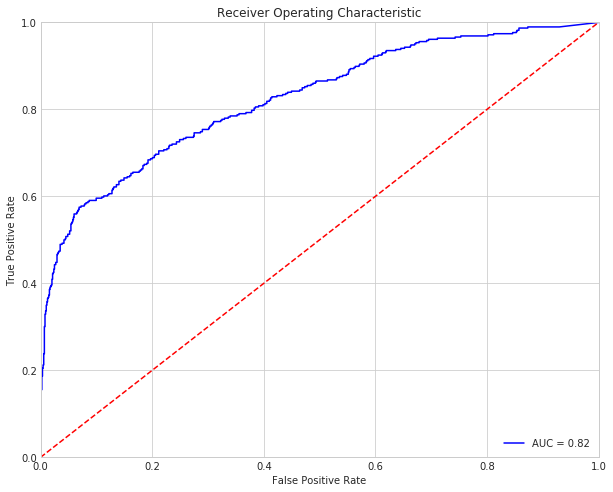

Optimal Threshold is 0.23665183147708374
Accuracy on test data is: 0.7375886524822695


Predicted  False  True  __all__
Actual                         
False        653   230      883
True         103   283      386
__all__      756   513     1269

In [54]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [55]:
table_80_50_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.3.2 Logistic Regression

In [56]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[10000],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


,0,1,2,3,4,5,6,7,8
index,C,dual,fit_intercept,intercept_scaling,max_iter,multi_class,penalty,solver,tol
0,0.5,False,True,0.7,10000,multinomial,l2,sag,0.1


Accuracy of the  Logistic  model for the training data is: 0.7806464327946393

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       3320   237     3557
True         876   641     1517
__all__     4196   878     5074

Accuracy of the  Logistic  model for test data is: 0.7832939322301025

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        824    59      883
True         216   170      386
__all__     1040   229     1269

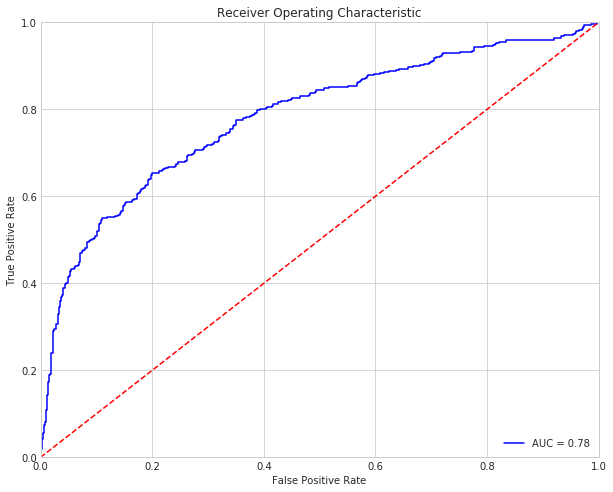

Optimal Threshold is 0.37833355431733223
Accuracy on test data is: 0.7084318360914106


Predicted  False  True  __all__
Actual                         
False        626   257      883
True         113   273      386
__all__      739   530     1269

In [57]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [58]:
table_80_50_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.3.3 Random Forest CLassifier 

In [59]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[200,500],criterion=['gini','entropy'],max_depth=[10,5],min_samples_split=[10,5],
                  min_samples_leaf=[10,5],min_weight_fraction_leaf=[0.1,0.3], max_features=['auto'],
                  max_leaf_nodes=[10,5],min_impurity_decrease=[0.1,0.3],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


,0,1,2,3,4,5,6,7,8,9,10,11
index,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,oob_score,random_state,verbose
0,gini,10,auto,10,0.1,10,10,0.1,200,False,0,0


Accuracy of the  Random Forest Trees  model for the training data is: 0.7010248324793062

Confusion Matrix for Training data is:


Predicted     0  1  __all__
Actual                     
0          3557  0     3557
1          1517  0     1517
__all__    5074  0     5074

Accuracy of the  Random Forest Trees  model for test data is: 0.6958234830575256

Confusion Matrix for test data is:


Predicted     0  1  __all__
Actual                     
0           883  0      883
1           386  0      386
__all__    1269  0     1269

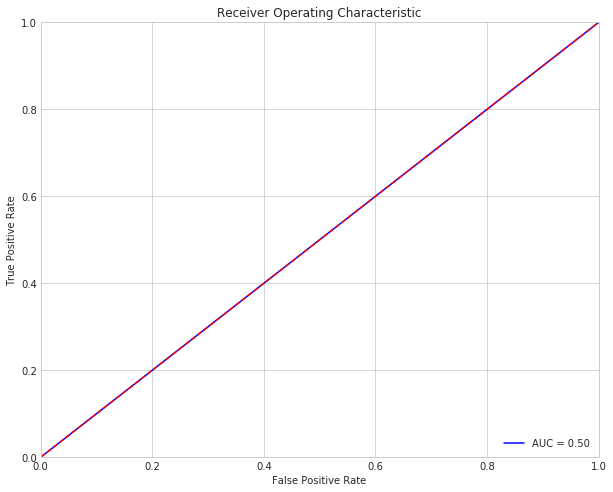

Optimal Threshold is 1.2991702798581002
Accuracy on test data is: 0.6958234830575256


Predicted   0.0  1.0  __all__
Actual                       
0.0         883    0      883
1.0         386    0      386
__all__    1269    0     1269

In [60]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [61]:
table_80_50_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

3557
0
0
3557
1517
0
0
1517
1.0
0.0
0.0
1.0
883
0
0
883
386
0
0
386
1.0
0.0
0.0
1.0
883
0
0
883
386
0
0
386
1.0
0.0
0.0
1.0


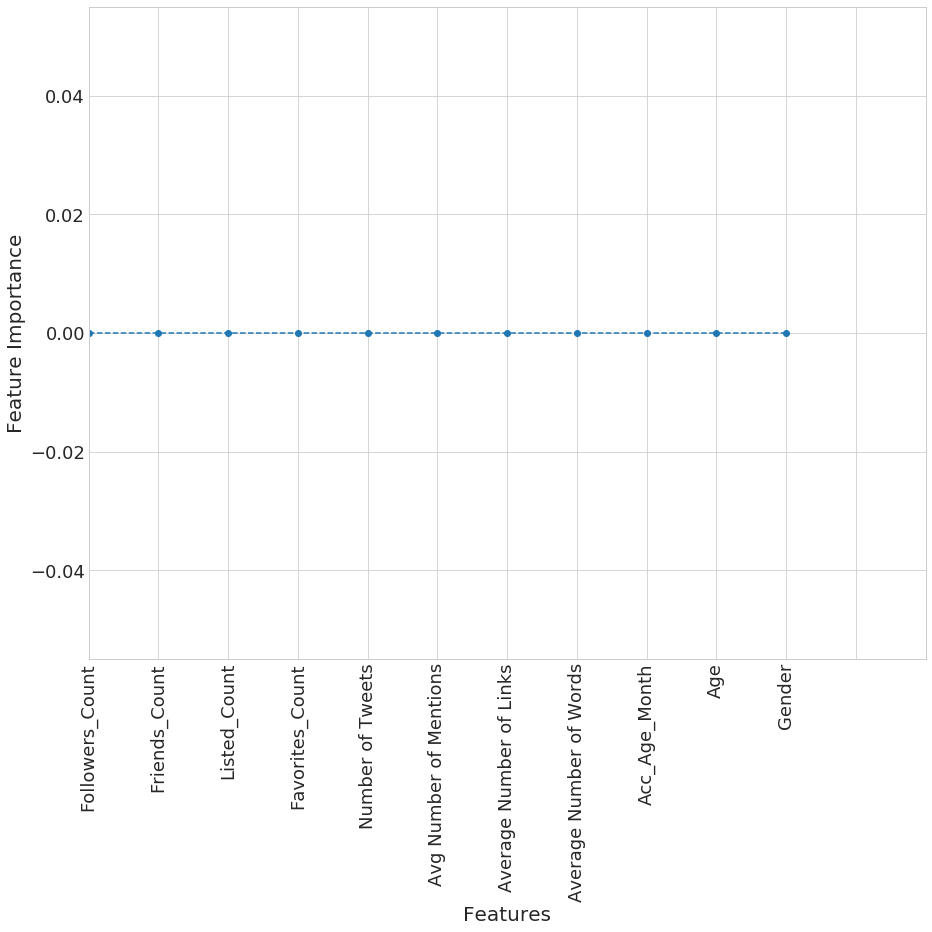

In [62]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [63]:
pd.Series(rf.feature_importances_,index=columns)

Followers_Count            0.0
Friends_Count              0.0
Listed_Count               0.0
Favorites_Count            0.0
Number of Tweets           0.0
Avg Number of Mentions     0.0
Average Number of Links    0.0
Average Number of Words    0.0
Acc_Age_Month              0.0
Age                        0.0
Gender                     0.0
dtype: float64

##### 1.3.4 AdaBoost Classifier 

In [64]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


,0,1,2,3
index,algorithm,learning_rate,n_estimators,random_state
0,SAMME.R,1,50,0


Accuracy of the  AdaBoostClassifier  model for the training data is: 0.8423334647221127

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       3387   170     3557
True         630   887     1517
__all__     4017  1057     5074

Accuracy of the  AdaBoostClassifier  model for test data is: 0.843183609141056

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        842    41      883
True         158   228      386
__all__     1000   269     1269

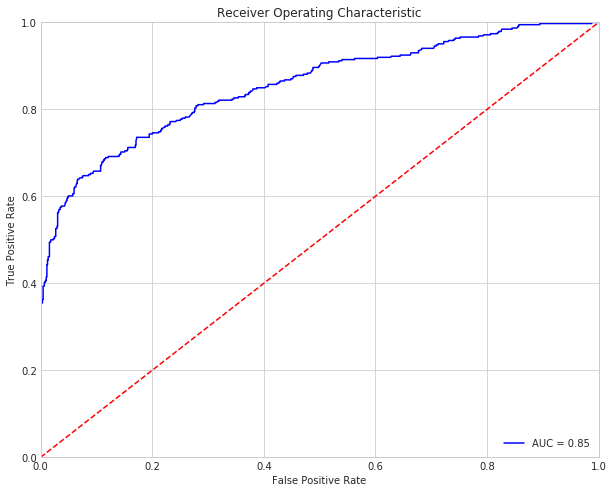

Optimal Threshold is 0.4945015518802041
Accuracy on test data is: 0.7683215130023641


Predicted  False  True  __all__
Actual                         
False        679   204      883
True          90   296      386
__all__      769   500     1269

In [65]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [66]:
table_80_50_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

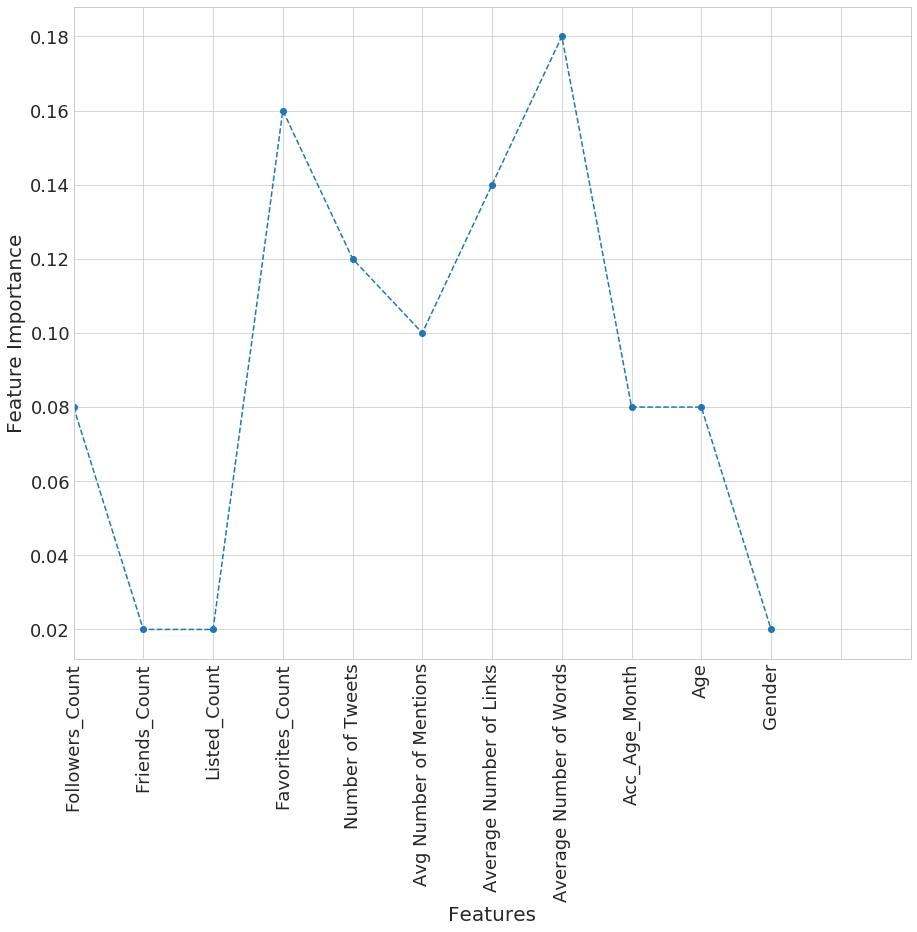

In [67]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0,12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [68]:
pd.Series(ada.feature_importances_,index=columns)

Followers_Count            0.08
Friends_Count              0.02
Listed_Count               0.02
Favorites_Count            0.16
Number of Tweets           0.12
Avg Number of Mentions     0.10
Average Number of Links    0.14
Average Number of Words    0.18
Acc_Age_Month              0.08
Age                        0.08
Gender                     0.02
dtype: float64

##### 1.3.5 GradientBoosting Classifier

In [69]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.2,deviance,5,0.1,50,0,1


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.8563263697280252

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       3433   124     3557
True         605   912     1517
__all__     4038  1036     5074

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.851063829787234

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        852    31      883
True         158   228      386
__all__     1010   259     1269

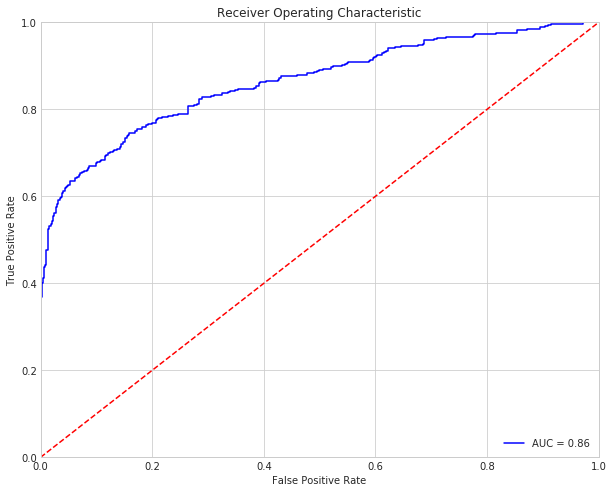

Optimal Threshold is 0.22558387959800988
Accuracy on test data is: 0.7817178881008668


Predicted  False  True  __all__
Actual                         
False        691   192      883
True          85   301      386
__all__      776   493     1269

In [70]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [71]:
table_80_50_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

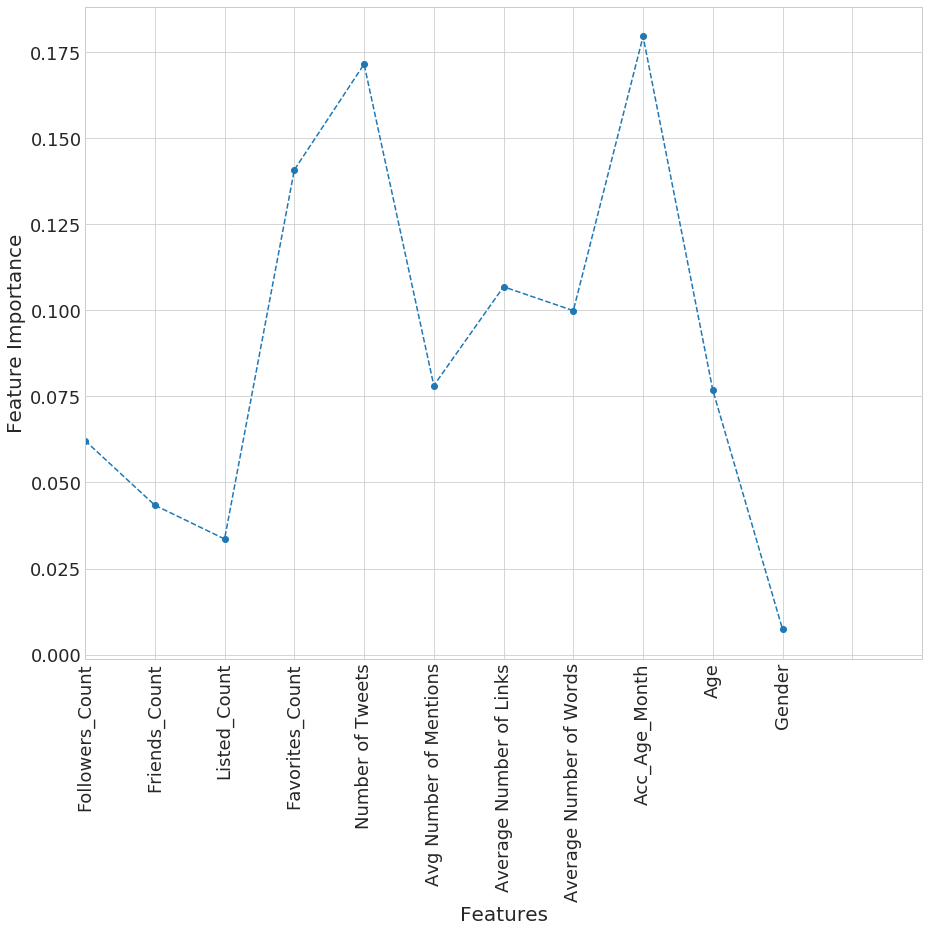

In [72]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [73]:
pd.Series(gbc.feature_importances_,index=columns)

Followers_Count            0.062150
Friends_Count              0.043393
Listed_Count               0.033582
Favorites_Count            0.140791
Number of Tweets           0.171495
Avg Number of Mentions     0.078160
Average Number of Links    0.106847
Average Number of Words    0.099909
Acc_Age_Month              0.179563
Age                        0.076796
Gender                     0.007313
dtype: float64

##### 1.3.6 ExtraTree Classifier

In [74]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,max_depth,max_features,min_impurity_decrease,min_samples_leaf,min_samples_split,random_state,splitter
0,entropy,20,auto,0.001,2,5,0,best


Accuracy of the  Extra Decision Tree  model for the training data is: 0.8512022073314939

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       3399   158     3557
True         597   920     1517
__all__     3996  1078     5074

Accuracy of the  Extra Decision Tree  model for test data is: 0.8211189913317573

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        822    61      883
True         166   220      386
__all__      988   281     1269

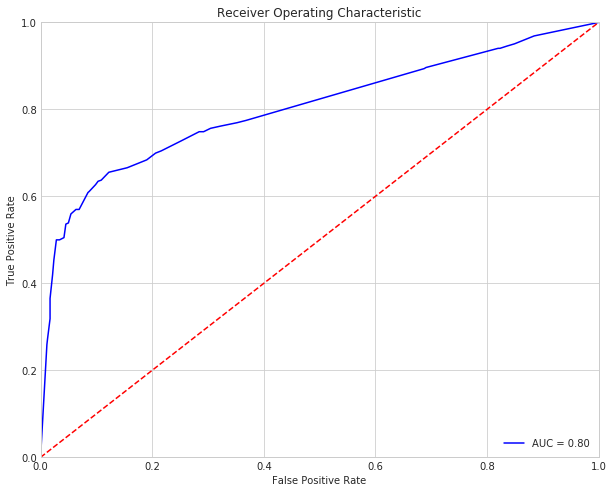

Optimal Threshold is 0.21910112359550563
Accuracy on test data is: 0.7596532702915682


Predicted  False  True  __all__
Actual                         
False        692   191      883
True         114   272      386
__all__      806   463     1269

In [75]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [76]:
table_80_50_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

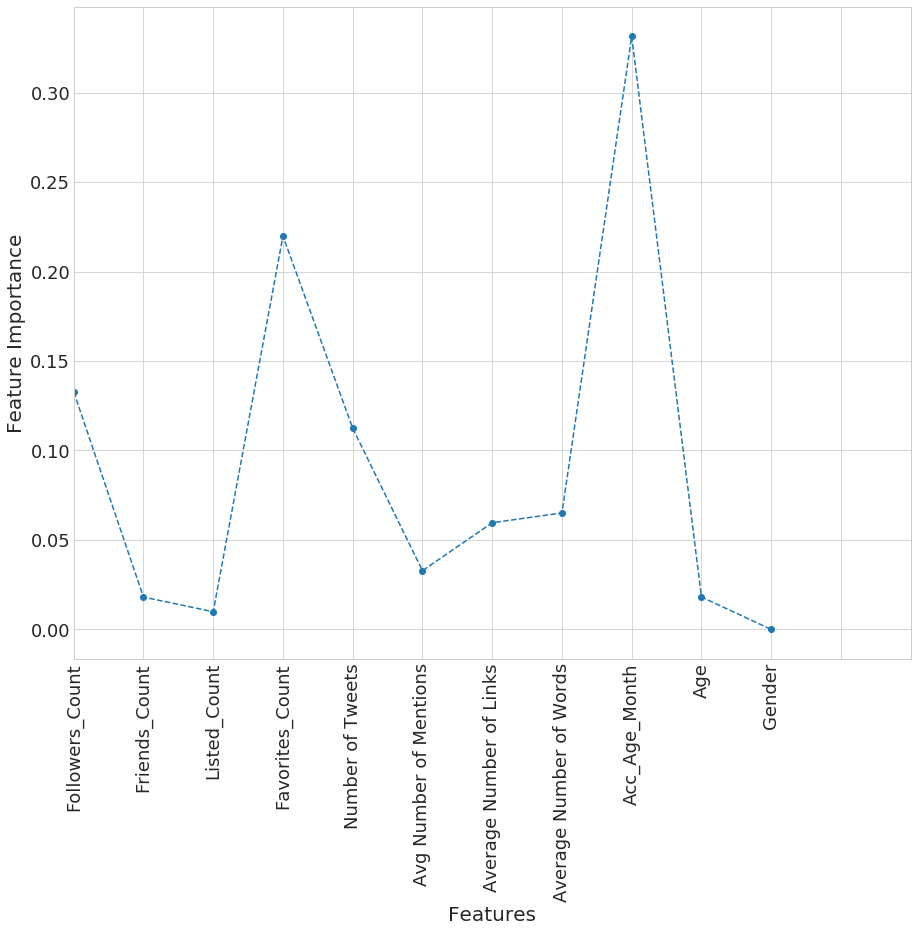

In [77]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [78]:
pd.Series(ext.feature_importances_,index=columns)

Followers_Count            0.132744
Friends_Count              0.018103
Listed_Count               0.009870
Favorites_Count            0.219799
Number of Tweets           0.112451
Avg Number of Mentions     0.032815
Average Number of Links    0.059623
Average Number of Words    0.065088
Acc_Age_Month              0.331376
Age                        0.018131
Gender                     0.000000
dtype: float64

##### 1.3.7 Bagging Classifier

In [79]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[300,500,100], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


,0,1,2,3,4,5,6
index,bootstrap,bootstrap_features,max_features,max_samples,n_estimators,oob_score,random_state
0,True,True,0.6,0.3,500,True,0


Accuracy of the  Bagging  model for the training data is: 0.9138746551044541

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       3555     2     3557
True         435  1082     1517
__all__     3990  1084     5074

Accuracy of the  Bagging  model for test data is: 0.8392434988179669

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        866    17      883
True         187   199      386
__all__     1053   216     1269

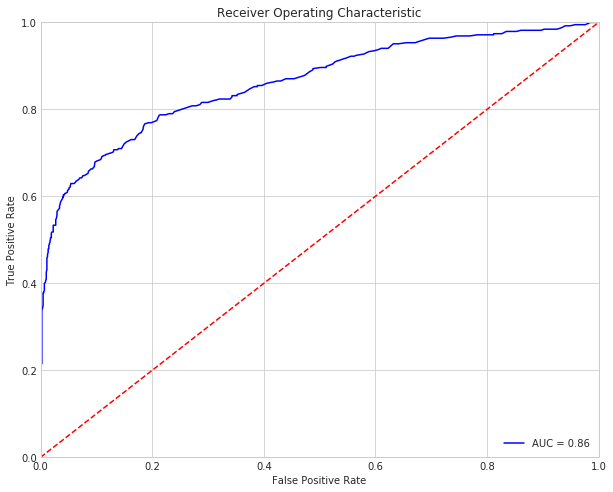

Optimal Threshold is 0.294
Accuracy on test data is: 0.7872340425531915


Predicted  False  True  __all__
Actual                         
False        696   187      883
True          83   303      386
__all__      779   490     1269

In [80]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [81]:
table_80_50_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.3.8 Voting Classifier

In [82]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The training accuracy is : 0.9262908947575877


/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Predicted  False  True  __all__
Actual                         
False       3552     5     3557
True         369  1148     1517
__all__     3921  1153     5074

The test accuracy is: 0.8289992119779354


Predicted  False  True  __all__
Actual                         
False        856    27      883
True         190   196      386
__all__     1046   223     1269

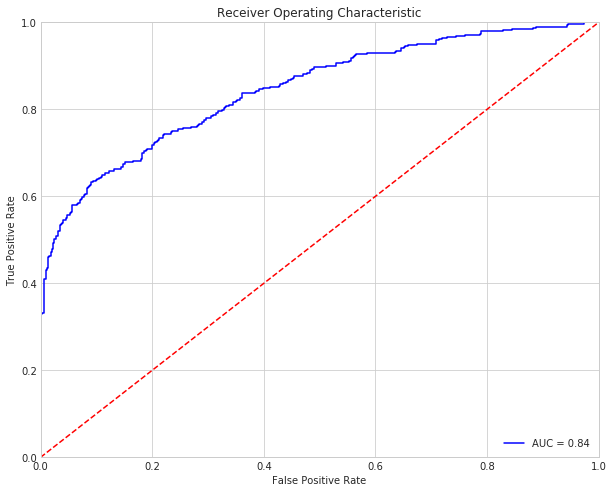

Optimal Threshold is 0.2947489345824316
Accuracy on test data is: 0.7525610717100079


Predicted  False  True  __all__
Actual                         
False        665   218      883
True          96   290      386
__all__      761   508     1269

In [83]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [84]:
table_80_50_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.3.9 Deep Learning

In [85]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=11))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.8872684273232989


Predicted  False  True  __all__
Actual                         
False       3462    95     3557
True         477  1040     1517
__all__     3939  1135     5074

The accuracy of the model on test data is: 0.8234830575256107


Predicted  False  True  __all__
Actual                         
False        824    59      883
True         165   221      386
__all__      989   280     1269

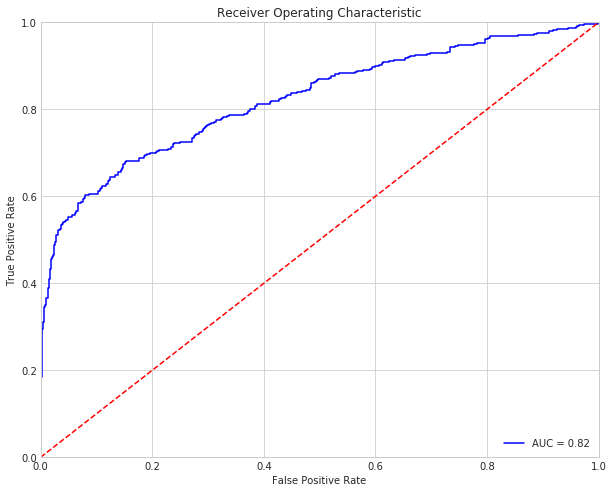

Optimal Threshold is 0.17203923
Accuracy of Logistic Model on training data is: 0.7281323877068558


Predicted  False  True  __all__
Actual                         
False        644   239      883
True         106   280      386
__all__      750   519     1269

In [86]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [87]:
table_80_50_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 1.3.10 Deep Learning with Grid Search

In [88]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=11))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.4min finished


The accuracy of the model on training data is: 0.8157272368939693


Predicted  False  True  __all__
Actual                         
False       3329   228     3557
True         707   810     1517
__all__     4036  1038     5074

The accuracy of the model on test data is: 0.8258471237194641


Predicted  False  True  __all__
Actual                         
False        838    45      883
True         176   210      386
__all__     1014   255     1269

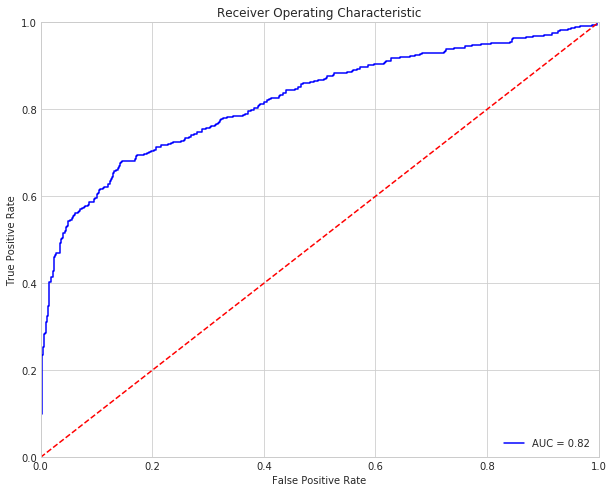

Optimal Threshold is 0.2988911
Accuracy on test data is: 0.7344365642237982


Predicted  False  True  __all__
Actual                         
False        649   234      883
True         103   283      386
__all__      752   517     1269

In [89]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [90]:
table_80_50_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### <a id='#1.3.1' style="text-decoration : none; color: #000000;">1.3.1 Results </a>

In [91]:
table_80_50_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)
table_80_50_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_50_train)

print("Comparision Table for Test Accuracies:")
display(table_80_50_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_50_test_roc)

Comparision Table for Training Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,1.000000,1517.000000,3557.000000,0.000000,0.000000,0.000000,0.000000
LogisticRegression,0.780646,641.000000,3320.000000,237.000000,876.000000,0.066629,0.577456
RandomForestClassifier,0.701025,2493.545329,1063.454671,1063.454671,453.545329,0.701025,0.298975
AdaBoostClassifier,0.842333,887.000000,3387.000000,170.000000,630.000000,0.047793,0.415293
GradientBoostingClassifier,0.856326,912.000000,3433.000000,124.000000,605.000000,0.034861,0.398813
ExtraTreeClassifier,0.851202,920.000000,3399.000000,158.000000,597.000000,0.044419,0.393540
BaggingClassifier,0.913875,1082.000000,3555.000000,2.000000,435.000000,0.000562,0.286750
VotingClassifier,0.926291,1148.000000,3552.000000,5.000000,369.000000,0.001406,0.243243
Neural Network-1,0.887268,1040.000000,3462.000000,95.000000,477.000000,0.026708,0.314436


Comparision Table for Test Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.814815,177.000000,857.000000,26.000000,209.000000,0.029445,0.541451
LogisticRegression,0.783294,170.000000,824.000000,59.000000,216.000000,0.066818,0.559585
RandomForestClassifier,0.695823,614.412136,268.587864,268.587864,117.412136,0.695823,0.304177
AdaBoostClassifier,0.843184,228.000000,842.000000,41.000000,158.000000,0.046433,0.409326
GradientBoostingClassifier,0.851064,228.000000,852.000000,31.000000,158.000000,0.035108,0.409326
ExtraTreeClassifier,0.821119,220.000000,822.000000,61.000000,166.000000,0.069083,0.430052
BaggingClassifier,0.839243,199.000000,866.000000,17.000000,187.000000,0.019253,0.484456
VotingClassifier,0.828999,196.000000,856.000000,27.000000,190.000000,0.030578,0.492228
Neural Network-1,0.823483,221.000000,824.000000,59.000000,165.000000,0.066818,0.427461


Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


,accuracy,TP,TN,FP,FN,FPR,FNR,threshold,auc
index,,,,,,,,,
KNeighborsClassifier,0.737589,283.000000,653.000000,230.000000,103.000000,0.260476,0.266839,0.236652,0.824491
LogisticRegression,0.708432,273.000000,626.000000,257.000000,113.000000,0.291053,0.292746,0.378334,0.781999
RandomForestClassifier,0.695823,614.412136,268.587864,268.587864,117.412136,0.695823,0.304177,1.299170,0.500000
AdaBoostClassifier,0.768322,296.000000,679.000000,204.000000,90.000000,0.231031,0.233161,0.494502,0.854033
GradientBoostingClassifier,0.781718,301.000000,691.000000,192.000000,85.000000,0.217441,0.220207,0.225584,0.862636
ExtraTreeClassifier,0.759653,272.000000,692.000000,191.000000,114.000000,0.216308,0.295337,0.219101,0.802868
BaggingClassifier,0.787234,303.000000,696.000000,187.000000,83.000000,0.211778,0.215026,0.294000,0.861188
VotingClassifier,0.752561,290.000000,665.000000,218.000000,96.000000,0.246886,0.248705,0.294749,0.844897
Neural Network-1,0.728132,280.000000,644.000000,239.000000,106.000000,0.270668,0.274611,0.172039,0.822705


### <a id='2' style="text-decoration : none; color: #000000;"> 2 Vulnerable/Control 50:50</a>
#### <a id='2.1' style="text-decoration : none; color: #000000;"> 2.1 Loading Data </a>

In [92]:
nm=df2[df2.Malicious==0]
m=df2[df2.Malicious==1]

df2=m.append(nm.sample(frac=((len(m)/0.5)*0.5)/len(nm),random_state=10))

In [93]:
print("The number of Vulnerable/Control Cases:")
df2.Malicious.value_counts()

The number of Vulnerable/Control Cases:


1    1903
0    1903
Name: Malicious, dtype: int64

In [94]:
### Function get_params takes as input a grid search model and prints out the best parameters for the model and 
### prints the best accuracy of the model
def get_params(grid,model_name=''):
    print("Best Parameters are :")
    display(pd.DataFrame.from_dict(grid.best_params_, orient='index').reset_index().transpose())

### The function takes as input the model, X and Y data to generate the confusion matrix  
def get_cm(model,a,b):
    y_pred=model.predict(a)
    cm=ConfusionMatrix(b,y_pred)
    display(cm)
    return cm
 
### The get accuracy plot takes as input a dataframe and a string for the title of the plot and displays a plot
### The function is primarily for plotting of accuracies for various classifiers for the same split.
def get_accuracy_plot(data,title=''):
    plt.figure(figsize=(12,8))
    plt.plot(data['accuracy'].values, '--o')
    plt.ylabel('Accuracy', fontsize=20)
    plt.xlabel('Classifier', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.xlim([0, 9])
    plt.title(title,size=18,y=1.05)
    plt.xticks(np.arange(10),data.index.get_values(),rotation=90)
    plt.legend(loc='upper right', fontsize=18)
    plt.show()

### Function grid takes as input an estimator, X_train,Y_Train,X_test and Y_test and a string represetning the name of the model
### We perform StratifiedKFold cross validation and grid search to hypertune the parameters of the model     
def grid_acc(kernel,params,x,y,x_test,y_test,model_name=''):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    grid_search=GridSearchCV(estimator=kernel,param_grid=parameters,scoring='accuracy',cv=kfold,n_jobs=-1)
    grid_search.fit(x,y)
    get_params(grid_search,model_name)
    acc_train=accuracy_score(y,grid_search.predict(x))
    print("Accuracy of the ",model_name," model for the training data is:",acc_train)
    print("\nConfusion Matrix for Training data is:")
    cm_train=get_cm(grid_search,x,y)
    acc_test=accuracy_score(y_test,grid_search.predict(x_test))
    print("Accuracy of the ",model_name," model for test data is:",acc_test)
    print("\nConfusion Matrix for test data is:")
    cm_test=get_cm(grid_search,x_test,y_test)
    return grid_search,cm_train,cm_test,acc_train,acc_test    

### Plot roc curve
def get_roc_curve(model,x_test,y_test):
    prob=model.predict_proba(x_test)
    preds=prob[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc =auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(threshold, index = i)})
    threshold=roc.ix[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
    print("Optimal Threshold is",threshold)
    y_pred_class=binarize(preds.reshape(1,-1),threshold)[0]
    accuracy=accuracy_score(y_test,y_pred_class)
    print("Accuracy on test data is:",accuracy)
    cm=ConfusionMatrix(y_test,y_pred_class)
    display(cm)
    return cm,accuracy,threshold,roc_auc

def get_roc_curve_deep_learning(model,x_test,y_test):
    prob=model.predict_proba(x_test)
    preds=prob
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc =auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(threshold, index = i)})
    threshold=roc.ix[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
    print("Optimal Threshold is",threshold)
    y_pred_class=binarize(preds.reshape(1,-1),threshold)[0]
    accuracy=accuracy_score(y_test,y_pred_class)
    print("Accuracy of Logistic Model on training data is:",accuracy)
    cm=ConfusionMatrix(y_test,y_pred_class)
    display(cm)
    return cm,accuracy,threshold,roc_auc

#### <a id='2.2' style="text-decoration : none; color: #000000;"> 2.2  70: 30 Train Test split </a>

In [95]:
Y=df2.Malicious.values
X=df2.iloc[:,df2.columns!='Malicious']
columns=X.columns.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 70:30")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.3)

The train/test split ratio is 70:30


In [96]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

##### 2.2.1 KNN

In [97]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


,0,1,2,3,4
index,algorithm,leaf_size,metric,n_neighbors,weights
0,auto,2,manhattan,50,distance


Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1337     0     1337
True           0  1327     1327
__all__     1337  1327     2664

Accuracy of the  KNN  model for test data is: 0.7600700525394045

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        494    72      566
True         202   374      576
__all__      696   446     1142

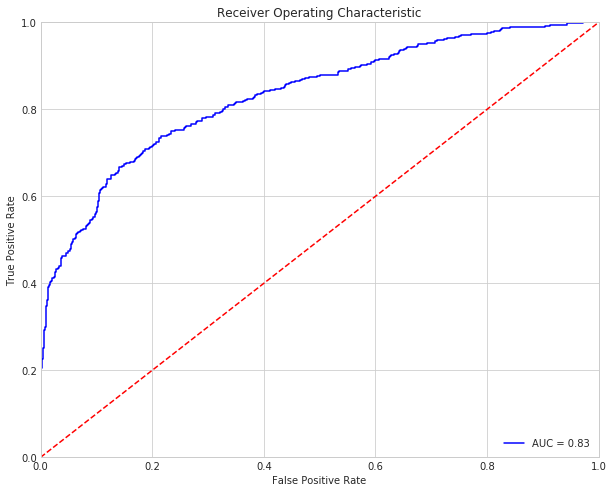

Optimal Threshold is 0.417060142579242
Accuracy on test data is: 0.7530647985989493


Predicted  False  True  __all__
Actual                         
False        427   139      566
True         143   433      576
__all__      570   572     1142

In [98]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [99]:
table_80_50_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 2.2.2 Logistic Regression

In [100]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[10000],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


,0,1,2,3,4,5,6,7,8
index,C,dual,fit_intercept,intercept_scaling,max_iter,multi_class,penalty,solver,tol
0,0.3,False,False,0.7,10000,multinomial,l2,sag,0.1


Accuracy of the  Logistic  model for the training data is: 0.7237237237237237

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1082   255     1337
True         481   846     1327
__all__     1563  1101     2664

Accuracy of the  Logistic  model for test data is: 0.7250437828371279

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        458   108      566
True         206   370      576
__all__      664   478     1142

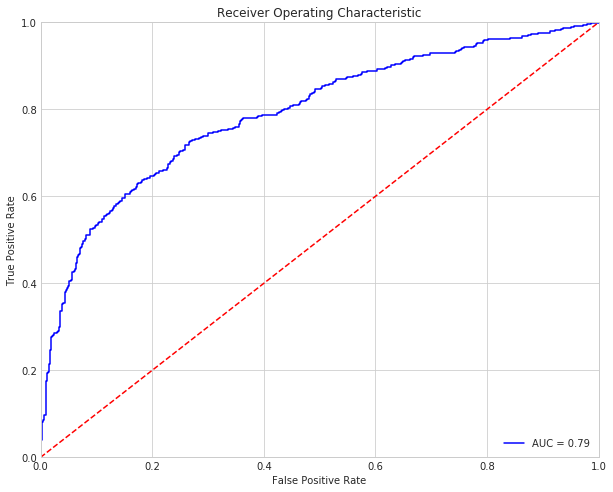

Optimal Threshold is 0.46923219165537894
Accuracy on test data is: 0.7285464098073555


Predicted  False  True  __all__
Actual                         
False        413   153      566
True         157   419      576
__all__      570   572     1142

In [101]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [102]:
table_80_50_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 2.2.3 RandomFOrest Classifier

In [103]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[200,500],criterion=['gini','entropy'],max_depth=[10,5],min_samples_split=[10,5],
                  min_samples_leaf=[10,5],min_weight_fraction_leaf=[0.1,0.3], max_features=['auto'],
                  max_leaf_nodes=[10,5],min_impurity_decrease=[0.1,0.3],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


,0,1,2,3,4,5,6,7,8,9,10,11
index,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,oob_score,random_state,verbose
0,entropy,10,auto,10,0.1,10,10,0.1,200,False,0,0


Accuracy of the  Random Forest Trees  model for the training data is: 0.6512762762762763

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1336     1     1337
True         928   399     1327
__all__     2264   400     2664

Accuracy of the  Random Forest Trees  model for test data is: 0.6313485113835376

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        565     1      566
True         420   156      576
__all__      985   157     1142

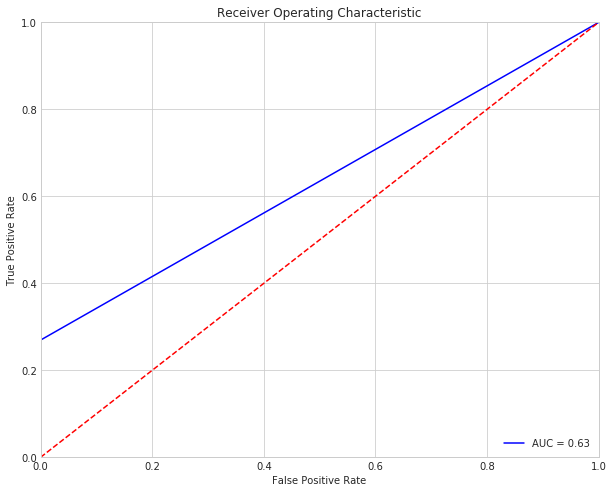

Optimal Threshold is 0.5007952781180708
Accuracy on test data is: 0.6322241681260946


Predicted  False  True  __all__
Actual                         
False        566     0      566
True         420   156      576
__all__      986   156     1142

In [104]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [105]:
table_80_50_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

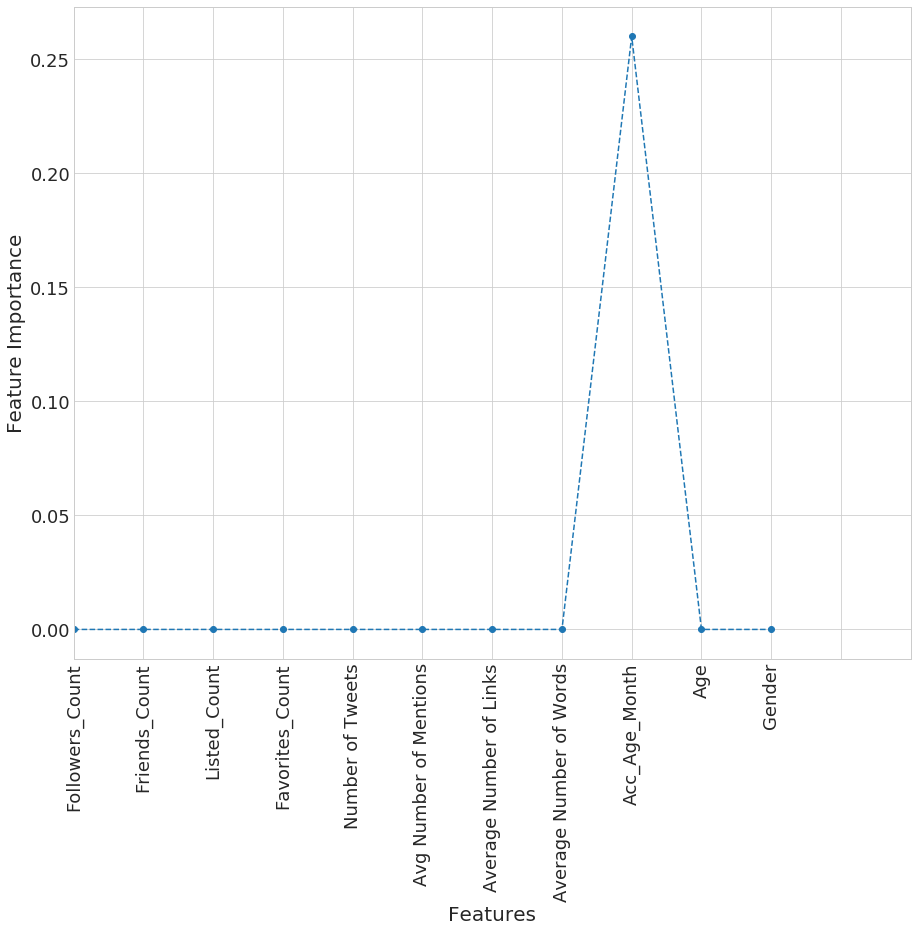

In [106]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [107]:
pd.Series(rf.feature_importances_,index=columns)

Followers_Count            0.00
Friends_Count              0.00
Listed_Count               0.00
Favorites_Count            0.00
Number of Tweets           0.00
Avg Number of Mentions     0.00
Average Number of Links    0.00
Average Number of Words    0.00
Acc_Age_Month              0.26
Age                        0.00
Gender                     0.00
dtype: float64

##### 2.2.4 Ada Boost Classifier

In [108]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


,0,1,2,3
index,algorithm,learning_rate,n_estimators,random_state
0,SAMME,0.5,400,0


Accuracy of the  AdaBoostClassifier  model for the training data is: 0.7864114114114115

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1189   148     1337
True         421   906     1327
__all__     1610  1054     2664

Accuracy of the  AdaBoostClassifier  model for test data is: 0.7802101576182137

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        490    76      566
True         175   401      576
__all__      665   477     1142

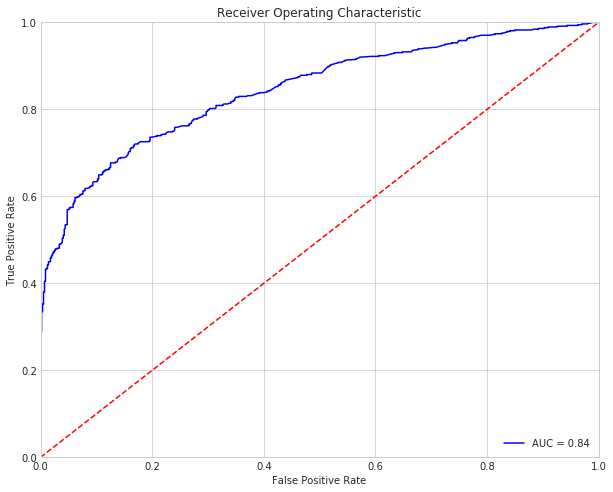

Optimal Threshold is 0.5024661024072153
Accuracy on test data is: 0.7583187390542907


Predicted  False  True  __all__
Actual                         
False        430   136      566
True         140   436      576
__all__      570   572     1142

In [109]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [110]:
table_80_50_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

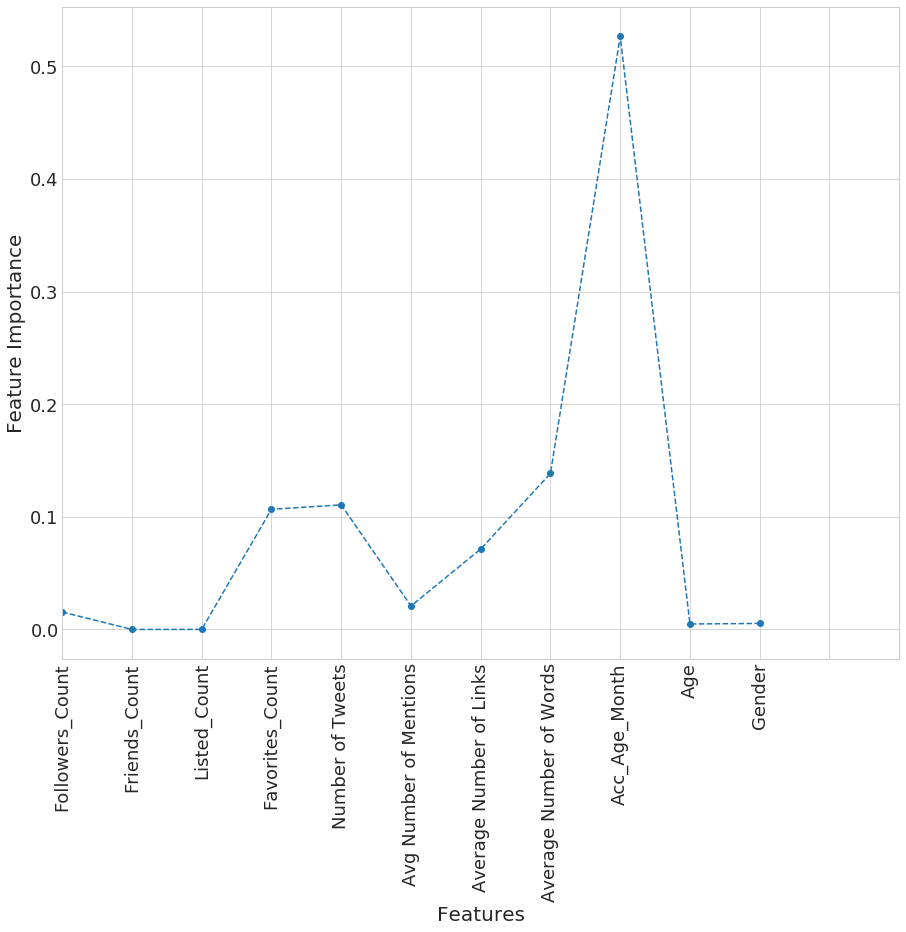

In [111]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0,12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [112]:
pd.Series(ada.feature_importances_,index=columns)

Followers_Count            0.015472
Friends_Count              0.000000
Listed_Count               0.000000
Favorites_Count            0.106667
Number of Tweets           0.110574
Avg Number of Mentions     0.020839
Average Number of Links    0.071359
Average Number of Words    0.138476
Acc_Age_Month              0.526474
Age                        0.004824
Gender                     0.005315
dtype: float64

##### 2.2.5 Gradient Boosting Classifier

In [113]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.05,exponential,10,0.1,150,0,0.7


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.8205705705705706

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1200   137     1337
True         341   986     1327
__all__     1541  1123     2664

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.7950963222416813

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        491    75      566
True         159   417      576
__all__      650   492     1142

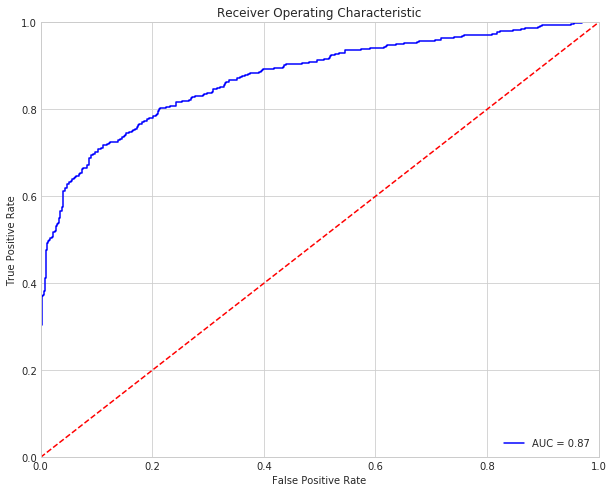

Optimal Threshold is 0.43233158060671245
Accuracy on test data is: 0.7907180385288967


Predicted  False  True  __all__
Actual                         
False        448   118      566
True         121   455      576
__all__      569   573     1142

In [114]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [115]:
table_80_50_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

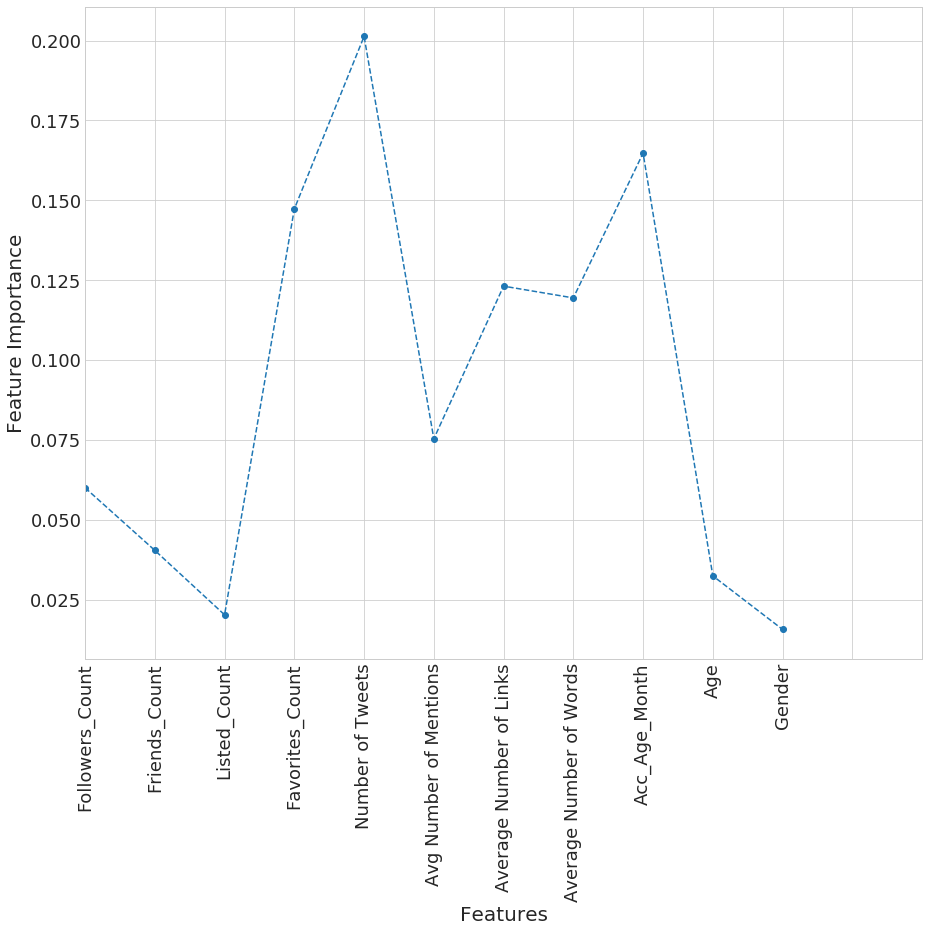

In [116]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [117]:
pd.Series(gbc.feature_importances_,index=columns)

Followers_Count            0.059996
Friends_Count              0.040407
Listed_Count               0.020227
Favorites_Count            0.147301
Number of Tweets           0.201320
Avg Number of Mentions     0.075338
Average Number of Links    0.123133
Average Number of Words    0.119447
Acc_Age_Month              0.164766
Age                        0.032412
Gender                     0.015653
dtype: float64

##### 2.2.6 Extra Tree classifier

In [118]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,max_depth,max_features,min_impurity_decrease,min_samples_leaf,min_samples_split,random_state,splitter
0,gini,10,auto,0.001,5,2,0,best


Accuracy of the  Extra Decision Tree  model for the training data is: 0.8119369369369369

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1219   118     1337
True         383   944     1327
__all__     1602  1062     2664

Accuracy of the  Extra Decision Tree  model for test data is: 0.7530647985989493

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        486    80      566
True         202   374      576
__all__      688   454     1142

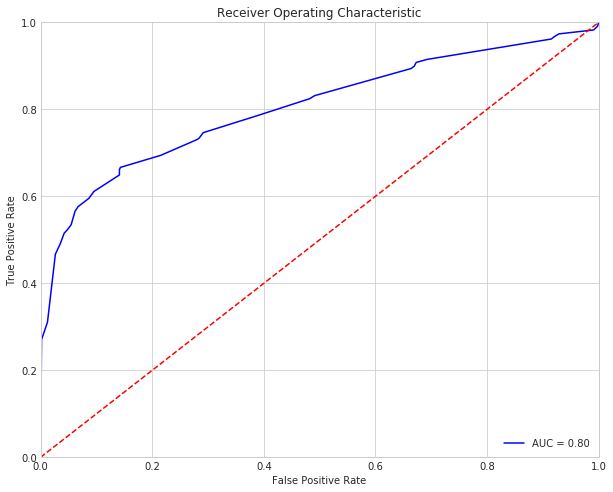

Optimal Threshold is 0.39552238805970147
Accuracy on test data is: 0.7390542907180385


Predicted  False  True  __all__
Actual                         
False        444   122      566
True         176   400      576
__all__      620   522     1142

In [119]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [120]:
table_80_50_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

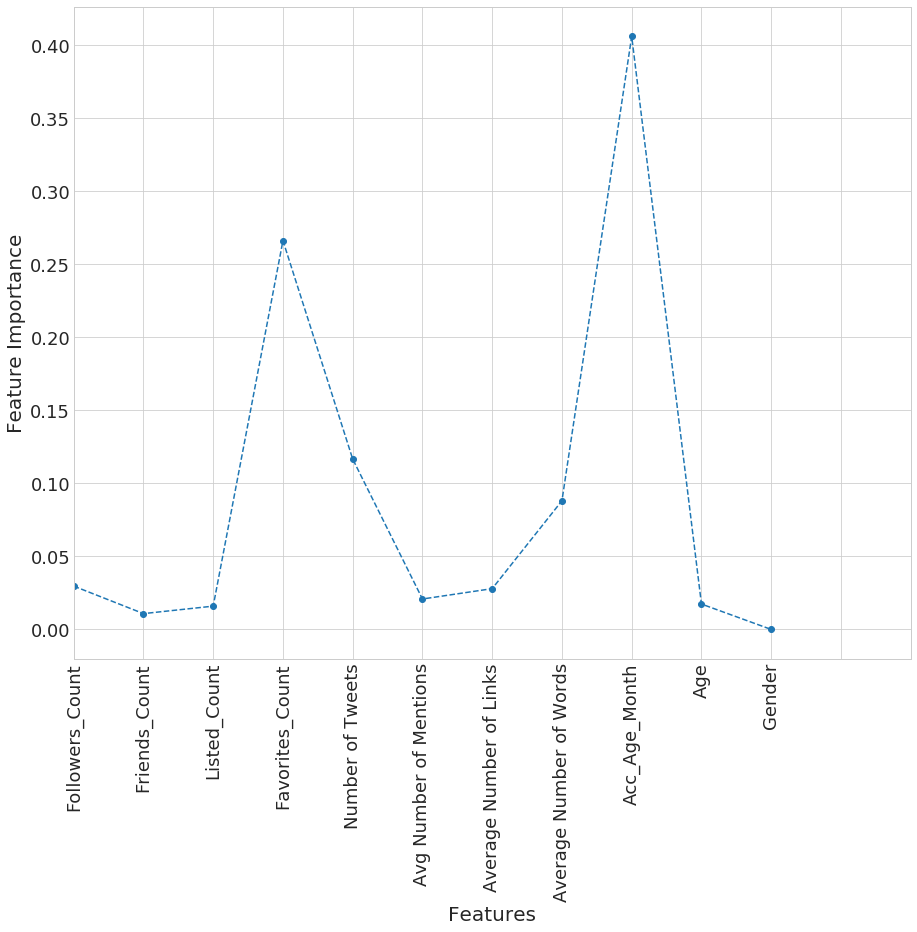

In [121]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [122]:
pd.Series(ext.feature_importances_,index=columns)

Followers_Count            0.029683
Friends_Count              0.010836
Listed_Count               0.015953
Favorites_Count            0.266299
Number of Tweets           0.116704
Avg Number of Mentions     0.020843
Average Number of Links    0.027934
Average Number of Words    0.088144
Acc_Age_Month              0.406218
Age                        0.017386
Gender                     0.000000
dtype: float64

##### 2.2.7 Bagging Classifier

In [123]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[300,500,100], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


,0,1,2,3,4,5,6
index,bootstrap,bootstrap_features,max_features,max_samples,n_estimators,oob_score,random_state
0,True,True,0.6,0.6,300,True,0


Accuracy of the  Bagging  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1337     0     1337
True           0  1327     1327
__all__     1337  1327     2664

Accuracy of the  Bagging  model for test data is: 0.7889667250437828

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        470    96      566
True         145   431      576
__all__      615   527     1142

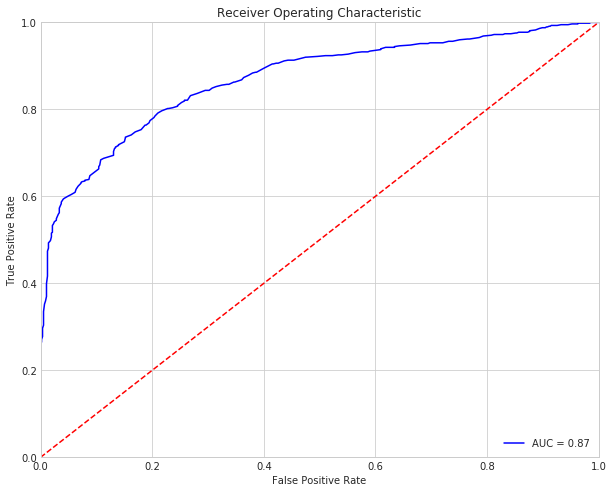

Optimal Threshold is 0.48
Accuracy on test data is: 0.7898423817863398


Predicted  False  True  __all__
Actual                         
False        450   116      566
True         124   452      576
__all__      574   568     1142

In [124]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [125]:
table_80_50_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 2.2.8 Voting Classifier

In [126]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The training accuracy is : 0.9703453453453453


/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Predicted  False  True  __all__
Actual                         
False       1320    17     1337
True          62  1265     1327
__all__     1382  1282     2664

The test accuracy is: 0.7600700525394045


Predicted  False  True  __all__
Actual                         
False        465   101      566
True         173   403      576
__all__      638   504     1142

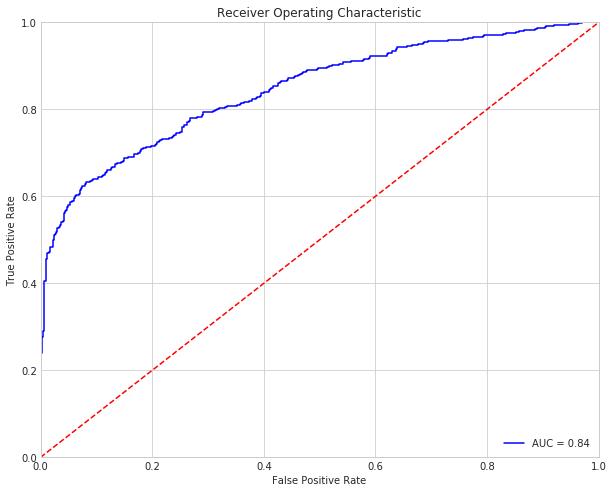

Optimal Threshold is 0.46217380793435453
Accuracy on test data is: 0.7486865148861647


Predicted  False  True  __all__
Actual                         
False        424   142      566
True         145   431      576
__all__      569   573     1142

In [127]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [128]:
table_80_50_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### 2.2.9 Deep Learning

In [129]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=11))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.8487237237237237


Predicted  False  True  __all__
Actual                         
False       1221   116     1337
True         287  1040     1327
__all__     1508  1156     2664

The accuracy of the model on test data is: 0.7478108581436077


Predicted  False  True  __all__
Actual                         
False        453   113      566
True         175   401      576
__all__      628   514     1142

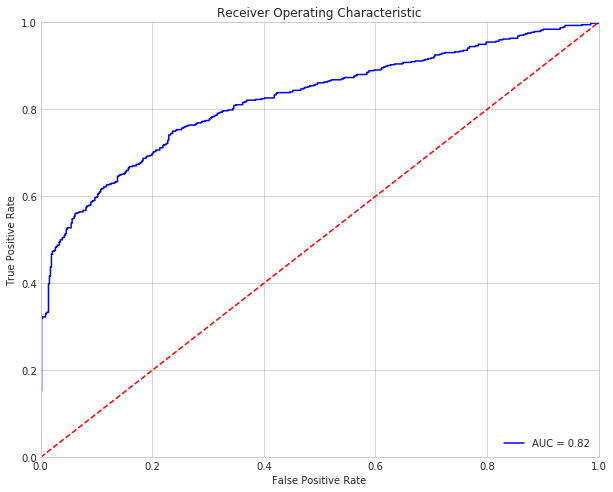

Optimal Threshold is 0.44120204
Accuracy of Logistic Model on training data is: 0.7539404553415061


Predicted  False  True  __all__
Actual                         
False        428   138      566
True         143   433      576
__all__      571   571     1142

In [130]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [131]:
table_80_50_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 2.2.10 Deep Learning with Grid Search

In [132]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=11))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.8min finished


The accuracy of the model on training data is: 0.7447447447447447


Predicted  False  True  __all__
Actual                         
False       1096   241     1337
True         439   888     1327
__all__     1535  1129     2664

The accuracy of the model on test data is: 0.7495621716287215


Predicted  False  True  __all__
Actual                         
False        456   110      566
True         176   400      576
__all__      632   510     1142

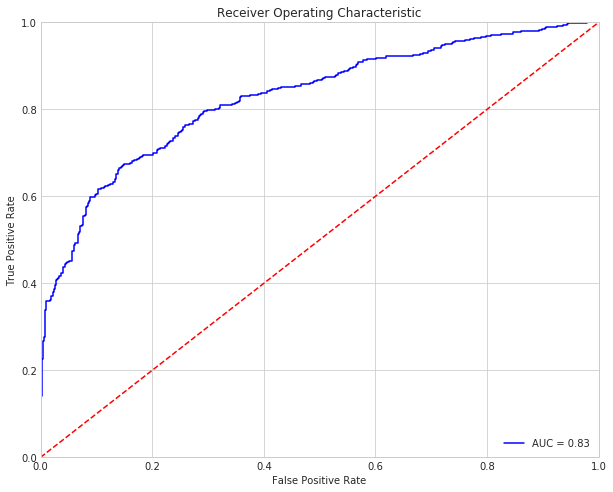

Optimal Threshold is 0.41497838
Accuracy on test data is: 0.7495621716287215


Predicted  False  True  __all__
Actual                         
False        425   141      566
True         145   431      576
__all__      570   572     1142

In [133]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [134]:
table_80_50_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

#### <a id'#2.2.1' style="text-decoration : none; color: #000000;">2.2.1 Results </a></ol></ul>

In [135]:
table_80_50_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)
table_80_50_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_50_train)

print("Comparision Table for Test Accuracies:")
display(table_80_50_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_50_test_roc)

Comparision Table for Training Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,1.000000,1327.0,1337.0,0.0,0.0,0.000000,0.000000
LogisticRegression,0.723724,846.0,1082.0,255.0,481.0,0.190726,0.362472
RandomForestClassifier,0.651276,399.0,1336.0,1.0,928.0,0.000748,0.699322
AdaBoostClassifier,0.786411,906.0,1189.0,148.0,421.0,0.110696,0.317257
GradientBoostingClassifier,0.820571,986.0,1200.0,137.0,341.0,0.102468,0.256971
ExtraTreeClassifier,0.811937,944.0,1219.0,118.0,383.0,0.088257,0.288621
BaggingClassifier,1.000000,1327.0,1337.0,0.0,0.0,0.000000,0.000000
VotingClassifier,0.970345,1265.0,1320.0,17.0,62.0,0.012715,0.046722
Neural Network-1,0.848724,1040.0,1221.0,116.0,287.0,0.086761,0.216277


Comparision Table for Test Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.760070,374.0,494.0,72.0,202.0,0.127208,0.350694
LogisticRegression,0.725044,370.0,458.0,108.0,206.0,0.190813,0.357639
RandomForestClassifier,0.631349,156.0,565.0,1.0,420.0,0.001767,0.729167
AdaBoostClassifier,0.780210,401.0,490.0,76.0,175.0,0.134276,0.303819
GradientBoostingClassifier,0.795096,417.0,491.0,75.0,159.0,0.132509,0.276042
ExtraTreeClassifier,0.753065,374.0,486.0,80.0,202.0,0.141343,0.350694
BaggingClassifier,0.788967,431.0,470.0,96.0,145.0,0.169611,0.251736
VotingClassifier,0.760070,403.0,465.0,101.0,173.0,0.178445,0.300347
Neural Network-1,0.747811,401.0,453.0,113.0,175.0,0.199647,0.303819


Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


,accuracy,TP,TN,FP,FN,FPR,FNR,threshold,auc
index,,,,,,,,,
KNeighborsClassifier,0.753065,433.0,427.0,139.0,143.0,0.245583,0.248264,0.417060,0.832269
LogisticRegression,0.728546,419.0,413.0,153.0,157.0,0.270318,0.272569,0.469232,0.790676
RandomForestClassifier,0.632224,156.0,566.0,0.0,420.0,0.000000,0.729167,0.500795,0.634773
AdaBoostClassifier,0.758319,436.0,430.0,136.0,140.0,0.240283,0.243056,0.502466,0.844607
GradientBoostingClassifier,0.790718,455.0,448.0,118.0,121.0,0.208481,0.210069,0.432332,0.873859
ExtraTreeClassifier,0.739054,400.0,444.0,122.0,176.0,0.215548,0.305556,0.395522,0.804582
BaggingClassifier,0.789842,452.0,450.0,116.0,124.0,0.204947,0.215278,0.480000,0.868965
VotingClassifier,0.748687,431.0,424.0,142.0,145.0,0.250883,0.251736,0.462174,0.844983
Neural Network-1,0.753940,433.0,428.0,138.0,143.0,0.243816,0.248264,0.441202,0.821794


###  <a id='2.3' style="text-decoration : none; color: #000000;"> 2.3  80:20 Train Test split </a>

In [136]:
Y=df2.Malicious.values
X=df2.iloc[:,df2.columns!='Malicious']
columns=X.columns.values

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,Y,random_state=0,test_size=0.2)

The train/test split ratio is 80:20


In [137]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test_roc=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','threshold','auc'])

##### 2.3.1 KNN

In [138]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
parameters = dict(n_neighbors=[20,30,50],weights=['uniform','distance'], algorithm=['auto','ball_tree'],
                  leaf_size=[2,5,10,15],metric=['euclidean','manhattan','chebyshev'])
knn_model,cm_train,cm_test,acc_train,acc_test =grid_acc(knn,parameters,X_train,Y_train,X_test,Y_test,"KNN")

Best Parameters are :


,0,1,2,3,4
index,algorithm,leaf_size,metric,n_neighbors,weights
0,auto,2,manhattan,50,distance


Accuracy of the  KNN  model for the training data is: 1.0

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1524     0     1524
True           0  1520     1520
__all__     1524  1520     3044

Accuracy of the  KNN  model for test data is: 0.7440944881889764

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        325    54      379
True         141   242      383
__all__      466   296      762

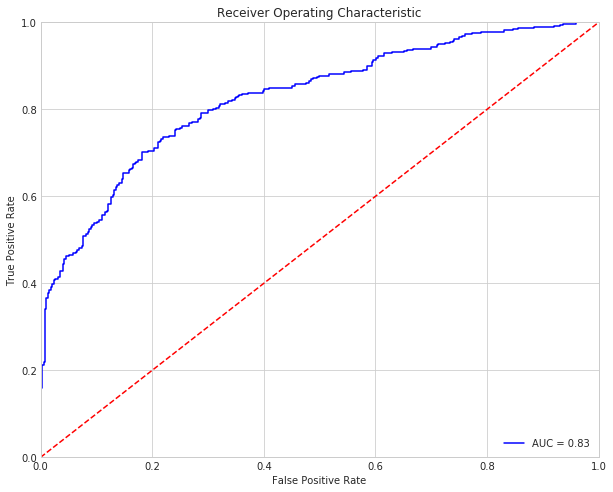

Optimal Threshold is 0.4137353669781335
Accuracy on test data is: 0.7545931758530183


Predicted  False  True  __all__
Actual                         
False        287    92      379
True          95   288      383
__all__      382   380      762

In [139]:
cm,accuracy,threshold,roc_auc=get_roc_curve(knn_model,X_test,Y_test)

In [140]:
table_80_50_train.loc[0]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[0] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[0]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 2.3.3 Logistic Regression

In [141]:
logistic=LogisticRegression()
parameters = dict(penalty=['l2'],dual=[False],C=[0.5,0.3,0.7],fit_intercept=[True,False],
                  intercept_scaling=[0.5,0.7],max_iter=[10000],solver=['newton-cg','lbfgs','sag'],
                  tol=[1e-5,1e-3,1e-1],multi_class=['ovr','multinomial']
                 )
log_model,cm_train,cm_test,acc_train,acc_test=grid_acc(logistic,parameters,X_train,Y_train,X_test,Y_test,"Logistic")

Best Parameters are :


,0,1,2,3,4,5,6,7,8
index,C,dual,fit_intercept,intercept_scaling,max_iter,multi_class,penalty,solver,tol
0,0.3,False,False,0.7,10000,multinomial,l2,sag,0.1


Accuracy of the  Logistic  model for the training data is: 0.7289750328515112

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1227   297     1524
True         528   992     1520
__all__     1755  1289     3044

Accuracy of the  Logistic  model for test data is: 0.7099737532808399

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        297    82      379
True         139   244      383
__all__      436   326      762

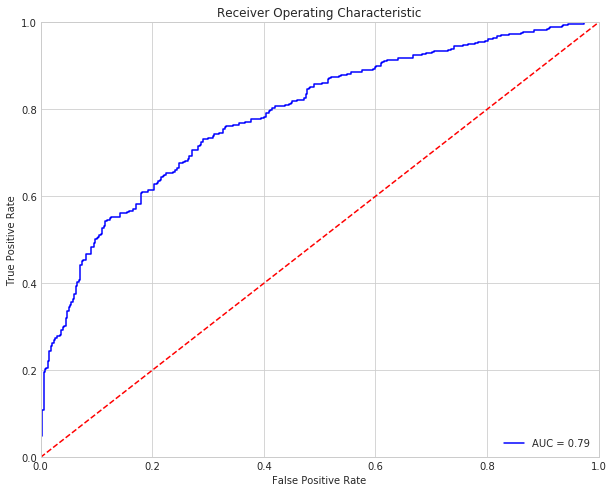

Optimal Threshold is 0.4709254565495578
Accuracy on test data is: 0.7165354330708661


Predicted  False  True  __all__
Actual                         
False        272   107      379
True         109   274      383
__all__      381   381      762

In [142]:
cm,accuracy,threshold,roc_auc=get_roc_curve(log_model,X_test,Y_test)

In [143]:
table_80_50_train.loc[1]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[1] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[1]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 2.3.3 Random Forest CLassifiere

In [144]:
rf=RandomForestClassifier()

parameters = dict(n_estimators=[200,500],criterion=['gini','entropy'],max_depth=[10,5],min_samples_split=[10,5],
                  min_samples_leaf=[10,5],min_weight_fraction_leaf=[0.1,0.3], max_features=['auto'],
                  max_leaf_nodes=[10,5],min_impurity_decrease=[0.1,0.3],oob_score=[False],
                  random_state=[0],verbose=[0])
rf_model,cm_train,cm_test,acc_train,acc_test=grid_acc(rf,parameters,X_train,Y_train,X_test,Y_test,"Random Forest Trees")

Best Parameters are :


,0,1,2,3,4,5,6,7,8,9,10,11
index,criterion,max_depth,max_features,max_leaf_nodes,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,oob_score,random_state,verbose
0,entropy,10,auto,10,0.1,10,10,0.1,200,False,0,0


Accuracy of the  Random Forest Trees  model for the training data is: 0.6527595269382391

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1522     2     1524
True        1055   465     1520
__all__     2577   467     3044

Accuracy of the  Random Forest Trees  model for test data is: 0.615485564304462

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        379     0      379
True         293    90      383
__all__      672    90      762

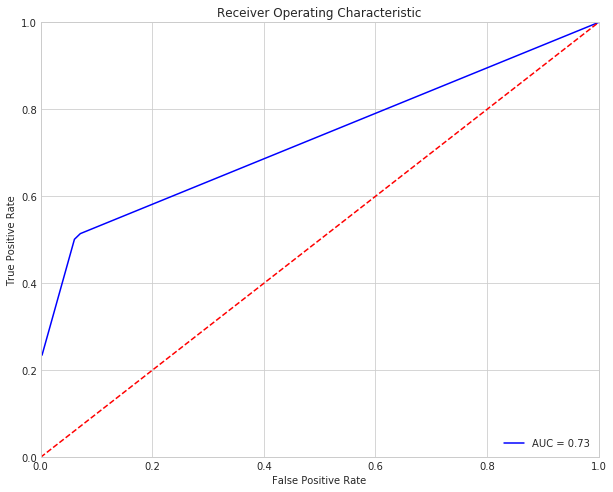

Optimal Threshold is 0.47915711103440883
Accuracy on test data is: 0.7191601049868767


Predicted  False  True  __all__
Actual                         
False        356    23      379
True         191   192      383
__all__      547   215      762

In [145]:
cm,accuracy,threshold,roc_auc=get_roc_curve(rf_model,X_test,Y_test)

In [146]:
table_80_50_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[2]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

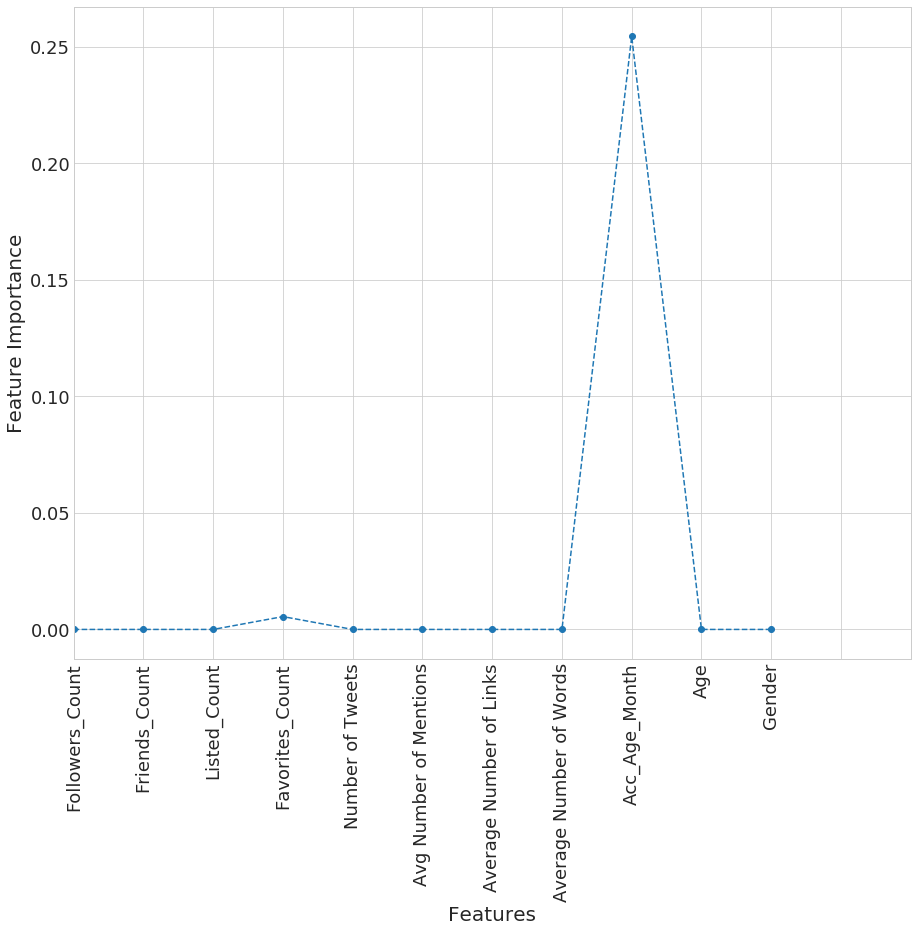

In [147]:
rf=RandomForestClassifier(**rf_model.best_params_)
rf.fit(X_train,Y_train)

fig = plt.figure(figsize=(15, 12))
plt.plot(rf.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [148]:
pd.Series(rf.feature_importances_,index=columns)

Followers_Count            0.000000
Friends_Count              0.000000
Listed_Count               0.000000
Favorites_Count            0.005508
Number of Tweets           0.000000
Avg Number of Mentions     0.000000
Average Number of Links    0.000000
Average Number of Words    0.000000
Acc_Age_Month              0.254492
Age                        0.000000
Gender                     0.000000
dtype: float64

##### 2.3.4 AdaBoost Classifier

In [149]:
ada=AdaBoostClassifier()
parameters=dict(n_estimators=[50,150,400],learning_rate=[0.5,1,1.5,5],algorithm=['SAMME','SAMME.R'],random_state=[0])
ada_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ada,parameters,X_train,Y_train,X_test,Y_test,"AdaBoostClassifier")

Best Parameters are :


,0,1,2,3
index,algorithm,learning_rate,n_estimators,random_state
0,SAMME,0.5,400,0


Accuracy of the  AdaBoostClassifier  model for the training data is: 0.7844940867279895

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1365   159     1524
True         497  1023     1520
__all__     1862  1182     3044

Accuracy of the  AdaBoostClassifier  model for test data is: 0.7637795275590551

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        332    47      379
True         133   250      383
__all__      465   297      762

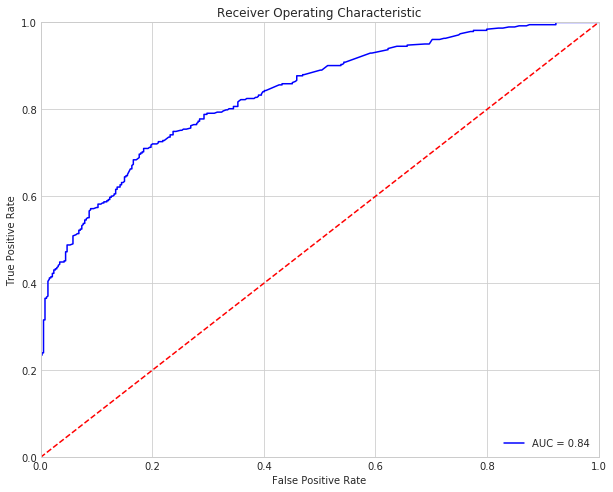

Optimal Threshold is 0.502045094275076
Accuracy on test data is: 0.7532808398950132


Predicted  False  True  __all__
Actual                         
False        287    92      379
True          96   287      383
__all__      383   379      762

In [150]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ada_model,X_test,Y_test)

In [151]:
table_80_50_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[3]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

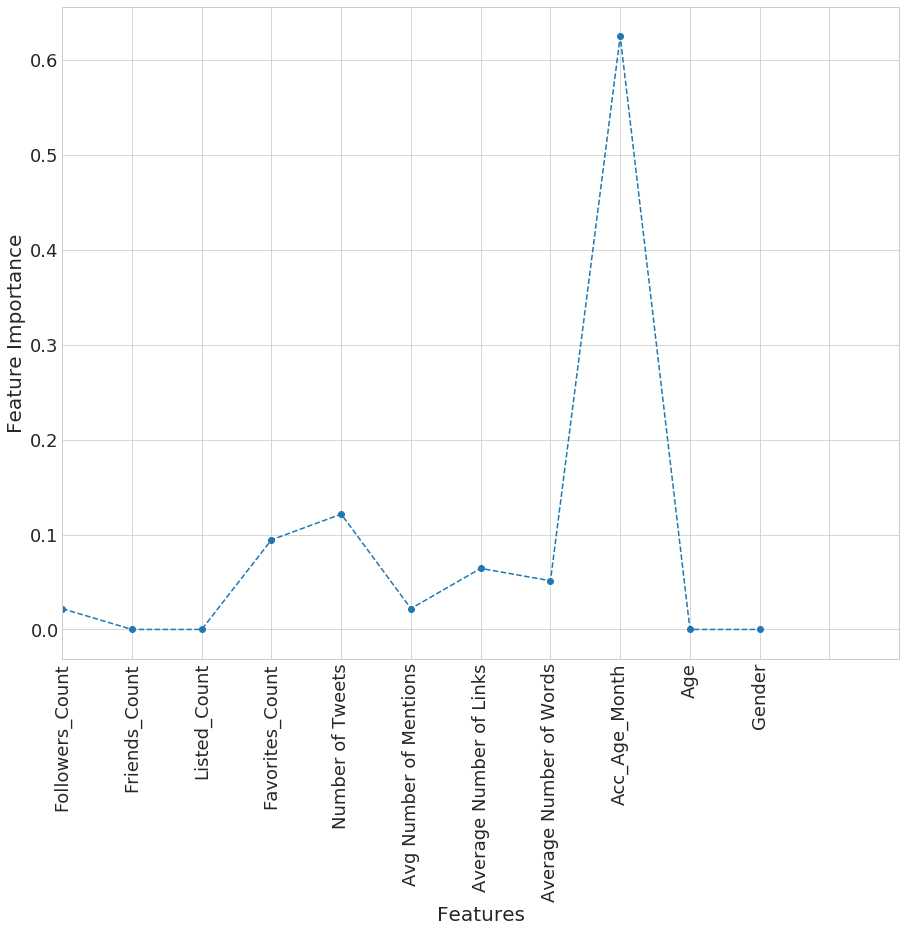

In [152]:
ada=AdaBoostClassifier(**ada_model.best_params_)
ada.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ada.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0,12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [153]:
pd.Series(ada.feature_importances_,index=columns)

Followers_Count            0.021904
Friends_Count              0.000000
Listed_Count               0.000000
Favorites_Count            0.094373
Number of Tweets           0.121463
Avg Number of Mentions     0.021991
Average Number of Links    0.064299
Average Number of Words    0.051263
Acc_Age_Month              0.624708
Age                        0.000000
Gender                     0.000000
dtype: float64

##### 2.3.5 Gradient Boosting Classifier

In [154]:
gbc=GradientBoostingClassifier()
parameters=dict(loss=['deviance','exponential'], learning_rate=[0.03,0.05,0.1,0.2],n_estimators=[50,100,150], criterion=['mse'],
                min_samples_split=[0.1,0.2,0.3],min_samples_leaf=[10,15,20,5],random_state=[0],subsample=[0.5,0.7,1])
gbc_model,cm_train,cm_test,acc_train,acc_test=grid_acc(gbc,parameters,X_train,Y_train,X_test,Y_test,"Gradient Boosting Classifier")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,learning_rate,loss,min_samples_leaf,min_samples_split,n_estimators,random_state,subsample
0,mse,0.1,exponential,20,0.1,150,0,1


Accuracy of the  Gradient Boosting Classifier  model for the training data is: 0.8370565045992115

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1388   136     1524
True         360  1160     1520
__all__     1748  1296     3044

Accuracy of the  Gradient Boosting Classifier  model for test data is: 0.7821522309711286

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        330    49      379
True         117   266      383
__all__      447   315      762

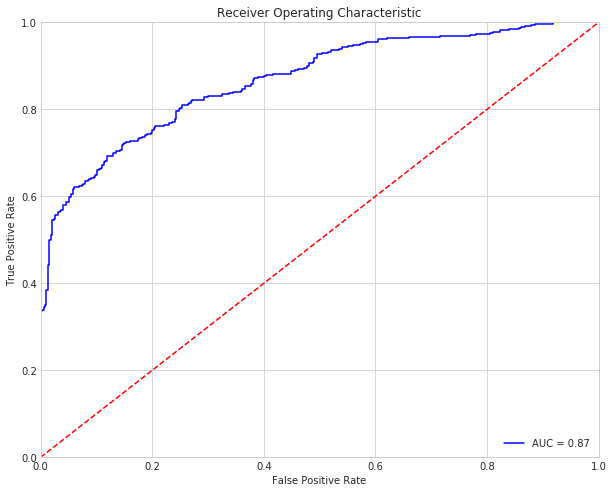

Optimal Threshold is 0.3974057333460745
Accuracy on test data is: 0.7677165354330708


Predicted  False  True  __all__
Actual                         
False        291    88      379
True          89   294      383
__all__      380   382      762

In [155]:
cm,accuracy,threshold,roc_auc=get_roc_curve(gbc_model,X_test,Y_test)

In [156]:
table_80_50_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[4]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

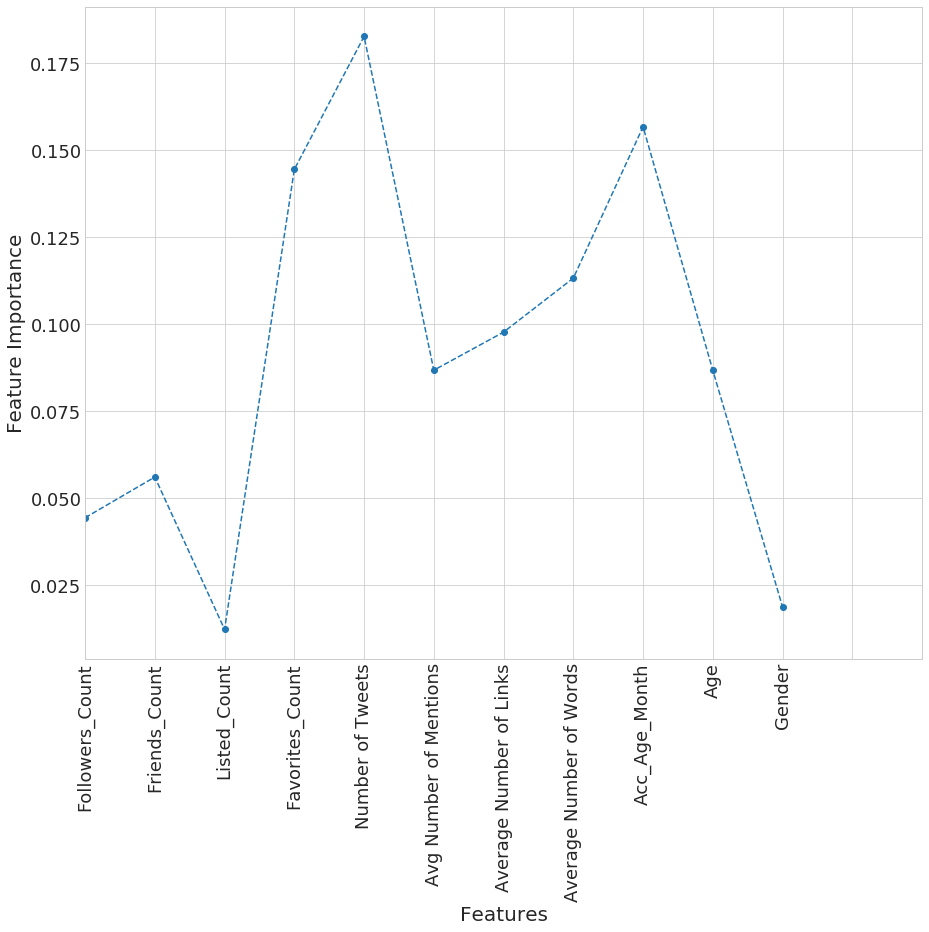

In [157]:
gbc=GradientBoostingClassifier(**gbc_model.best_params_)
gbc.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(gbc.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [158]:
pd.Series(gbc.feature_importances_,index=columns)

Followers_Count            0.044393
Friends_Count              0.056091
Listed_Count               0.012299
Favorites_Count            0.144496
Number of Tweets           0.182712
Avg Number of Mentions     0.086790
Average Number of Links    0.097738
Average Number of Words    0.113253
Acc_Age_Month              0.156738
Age                        0.086744
Gender                     0.018746
dtype: float64

##### 2.3.6 Extra Tree CLassifier

In [159]:
ext_tree=ExtraTreeClassifier()
parameters=dict(criterion=['gini','entropy'],splitter=['best','random'],max_features=['auto','sqrt'],max_depth=[10,20,30],
               min_samples_split=[2,3,5],min_samples_leaf=[2,3,5],random_state=[0],min_impurity_decrease=[1e-1,1e-3]
               )
ext_tree_model,cm_train,cm_test,acc_train,acc_test=grid_acc(ext_tree,parameters,X_train,Y_train,X_test,Y_test,"Extra Decision Tree")

Best Parameters are :


,0,1,2,3,4,5,6,7
index,criterion,max_depth,max_features,min_impurity_decrease,min_samples_leaf,min_samples_split,random_state,splitter
0,gini,10,auto,0.001,2,2,0,best


Accuracy of the  Extra Decision Tree  model for the training data is: 0.7992772667542707

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1348   176     1524
True         435  1085     1520
__all__     1783  1261     3044

Accuracy of the  Extra Decision Tree  model for test data is: 0.7532808398950132

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        318    61      379
True         127   256      383
__all__      445   317      762

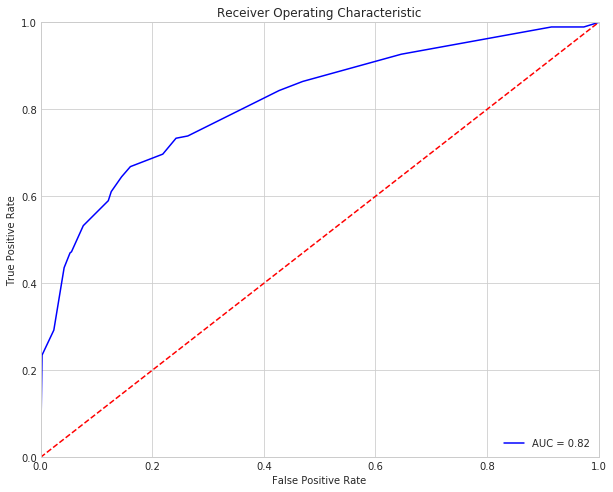

Optimal Threshold is 0.34210526315789475
Accuracy on test data is: 0.7454068241469817


Predicted  False  True  __all__
Actual                         
False        287    92      379
True         102   281      383
__all__      389   373      762

In [160]:
cm,accuracy,threshold,roc_auc=get_roc_curve(ext_tree_model,X_test,Y_test)

In [161]:
table_80_50_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[5]=([accuracy, cm.TP,cm.TN,cm.FP,cm.FN,cm.FPR,cm.FNR,threshold,roc_auc])

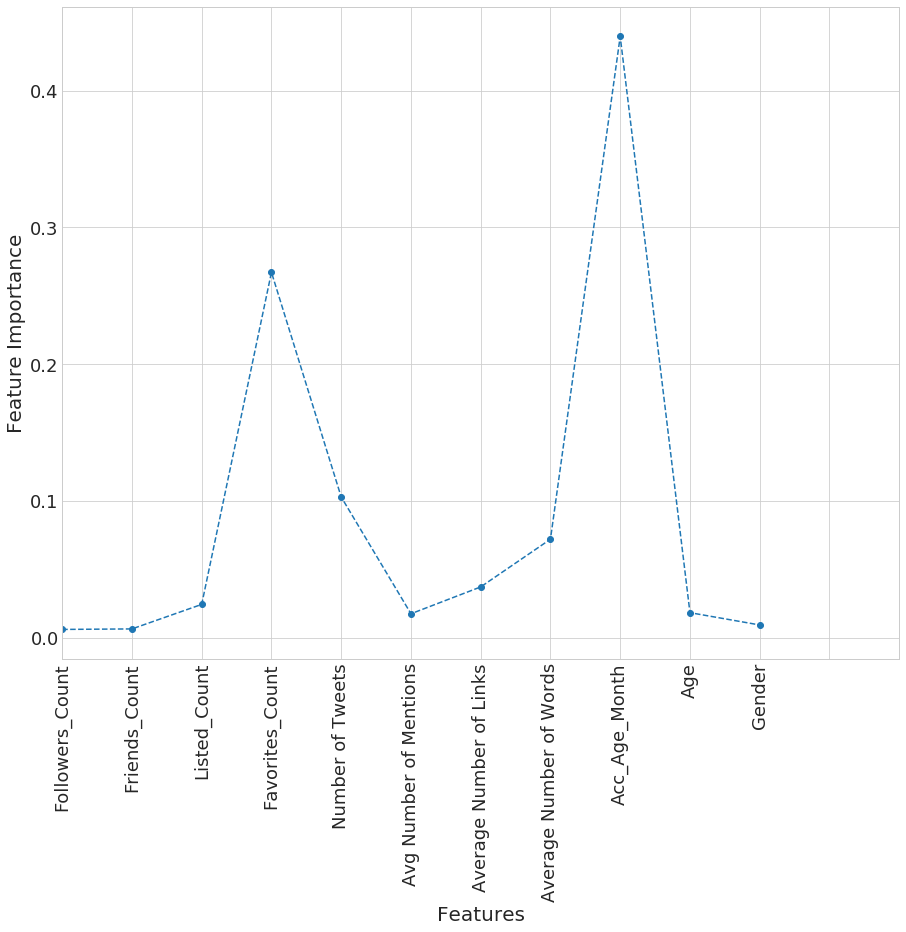

In [162]:
ext=ExtraTreeClassifier(**ext_tree_model.best_params_)
ext.fit(X_train,Y_train)
fig = plt.figure(figsize=(15, 12))
plt.plot(ext.feature_importances_, '--o')
plt.ylabel('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, 12])
plt.xticks(np.arange(12),columns,rotation=90)
plt.legend(loc='upper right', fontsize=18)
plt.show()

In [163]:
pd.Series(ext.feature_importances_,index=columns)

Followers_Count            0.005951
Friends_Count              0.006323
Listed_Count               0.024255
Favorites_Count            0.267159
Number of Tweets           0.102815
Avg Number of Mentions     0.017414
Average Number of Links    0.037042
Average Number of Words    0.071925
Acc_Age_Month              0.439677
Age                        0.018215
Gender                     0.009223
dtype: float64

##### 2.3.7 Bagging Classifier

In [164]:
bagging=BaggingClassifier()
parameters=dict(n_estimators=[300,500,100], max_samples=[0.6,0.4,0.3],max_features=[0.4,0.3,0.2,0.6],
                bootstrap=[True],bootstrap_features=[True],oob_score=[True],random_state=[0]
               )

bagging_model,cm_train,cm_test,acc_train,acc_test=grid_acc(bagging,parameters,X_train,Y_train,X_test,Y_test,"Bagging")

Best Parameters are :


,0,1,2,3,4,5,6
index,bootstrap,bootstrap_features,max_features,max_samples,n_estimators,oob_score,random_state
0,True,True,0.6,0.4,300,True,0


Accuracy of the  Bagging  model for the training data is: 0.9862023653088042

Confusion Matrix for Training data is:


Predicted  False  True  __all__
Actual                         
False       1516     8     1524
True          34  1486     1520
__all__     1550  1494     3044

Accuracy of the  Bagging  model for test data is: 0.7874015748031497

Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False        326    53      379
True         109   274      383
__all__      435   327      762

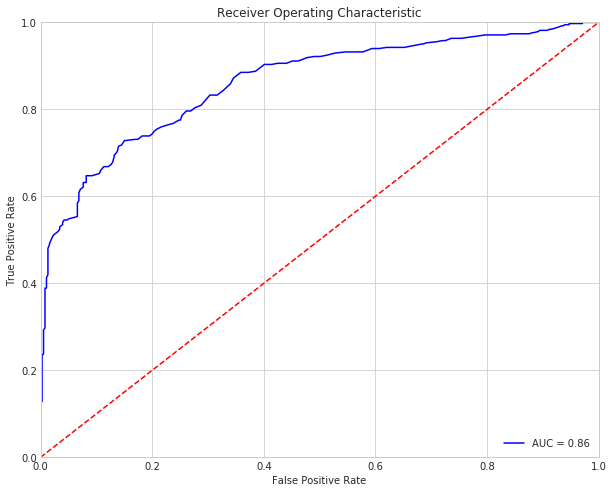

Optimal Threshold is 0.46
Accuracy on test data is: 0.7677165354330708


Predicted  False  True  __all__
Actual                         
False        292    87      379
True          90   293      383
__all__      382   380      762

In [165]:
cm,accuracy,threshold,roc_auc=get_roc_curve(bagging_model,X_test,Y_test)

In [166]:
table_80_50_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[6]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 2.3.8 Voting Classifier

In [167]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
print("The training accuracy is :",acc_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The test accuracy is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
cm_test

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


The training accuracy is : 0.9730617608409987


/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Predicted  False  True  __all__
Actual                         
False       1505    19     1524
True          63  1457     1520
__all__     1568  1476     3044

The test accuracy is: 0.7795275590551181


Predicted  False  True  __all__
Actual                         
False        315    64      379
True         104   279      383
__all__      419   343      762

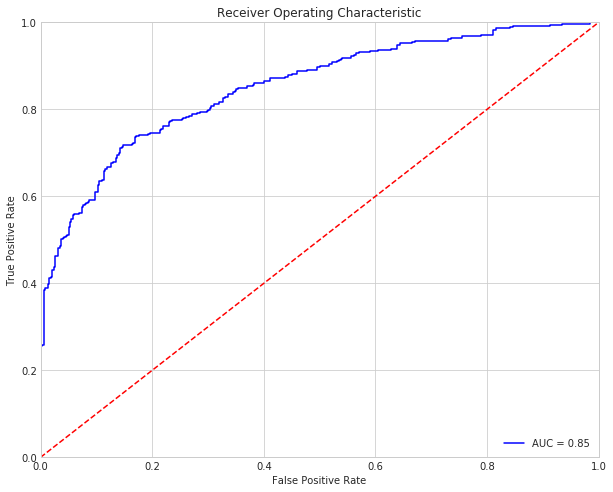

Optimal Threshold is 0.4545769912192507
Accuracy on test data is: 0.7690288713910761


Predicted  False  True  __all__
Actual                         
False        292    87      379
True          89   294      383
__all__      381   381      762

In [168]:
cm,accuracy,threshold,roc_auc=get_roc_curve(eclf,X_test,Y_test)

In [169]:
table_80_50_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[7]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 2.3.9 Deep Learning

In [170]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=11))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)

The accuracy of the model on training data is: 0.8561103810775296


Predicted  False  True  __all__
Actual                         
False       1423   101     1524
True         337  1183     1520
__all__     1760  1284     3044

The accuracy of the model on test data is: 0.7598425196850394


Predicted  False  True  __all__
Actual                         
False        316    63      379
True         120   263      383
__all__      436   326      762

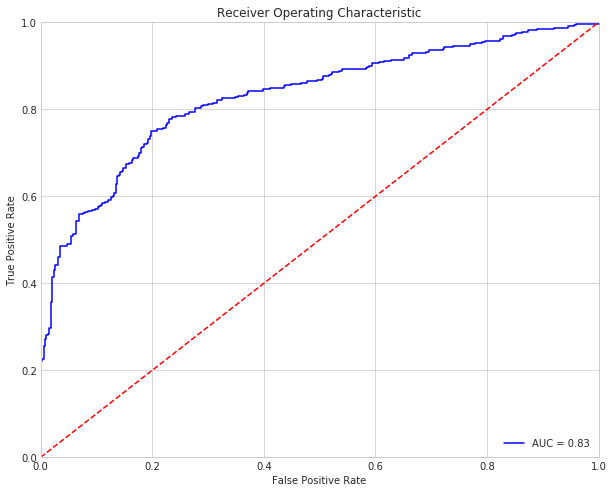

Optimal Threshold is 0.40685266
Accuracy of Logistic Model on training data is: 0.7703412073490814


Predicted  False  True  __all__
Actual                         
False        293    86      379
True          89   294      383
__all__      382   380      762

In [171]:
cm,accuracy,threshold,roc_auc=get_roc_curve_deep_learning(deep_learning,X_test,Y_test)

In [172]:
table_80_50_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[8]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

##### 2.3.10 Deep Learning with Grid Search

In [173]:
def build_keras_classifier(optimizer):
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=11))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=256,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=512,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return deep_learning
classifier=KerasClassifier(build_fn=build_keras_classifier,batch_size=20,nb_epoch=100,verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
parmas= {'batch_size':[20],'nb_epoch':[120],'optimizer':['adam','rmsprop']}
grid_search=GridSearchCV(estimator=classifier,param_grid=parmas,scoring='accuracy',cv=kfold,verbose=1)
grid_search.fit(X_train,Y_train)
acc_train=grid_search.score(X_train,Y_train)
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,grid_search.predict(X_train).reshape(1,len(X_train))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test,grid_search.predict(X_test).reshape(1,len(X_test))[0])
display(cm_test)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.4min finished


The accuracy of the model on training data is: 0.6744415243101183


Predicted  False  True  __all__
Actual                         
False       1488    36     1524
True         955   565     1520
__all__     2443   601     3044

The accuracy of the model on test data is: 0.6561679790026247


Predicted  False  True  __all__
Actual                         
False        367    12      379
True         250   133      383
__all__      617   145      762

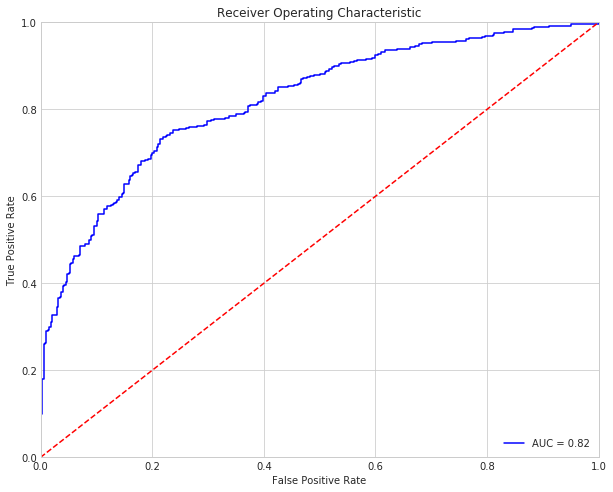

Optimal Threshold is 0.3046479
Accuracy on test data is: 0.7532808398950132


Predicted  False  True  __all__
Actual                         
False        286    93      379
True          95   288      383
__all__      381   381      762

In [174]:
cm,accuracy,threshold,roc_auc=get_roc_curve(grid_search,X_test,Y_test)

In [175]:
table_80_50_train.loc[9]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[9] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR])
table_80_50_test_roc.loc[9]=([accuracy, cm.TP,      cm.TN,      cm.FP,      cm.FN,      cm.FPR,      cm.FNR, threshold,roc_auc])

###   <a id='2.3.1' style="text-decoration : none; color: #000000;"> 2.3.1  Results </a>

In [176]:
table_80_50_train['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_test['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']
table_80_50_test_roc['index']=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier',
                            'Neural Network-1','Neural-Network-2']

table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)
table_80_50_test_roc.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_50_train)

print("Comparision Table for Test Accuracies:")
display(table_80_50_test)

print("Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:")
display(table_80_50_test_roc)

Comparision Table for Training Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,1.000000,1520.0,1524.0,0.0,0.0,0.000000,0.000000
LogisticRegression,0.728975,992.0,1227.0,297.0,528.0,0.194882,0.347368
RandomForestClassifier,0.652760,465.0,1522.0,2.0,1055.0,0.001312,0.694079
AdaBoostClassifier,0.784494,1023.0,1365.0,159.0,497.0,0.104331,0.326974
GradientBoostingClassifier,0.837057,1160.0,1388.0,136.0,360.0,0.089239,0.236842
ExtraTreeClassifier,0.799277,1085.0,1348.0,176.0,435.0,0.115486,0.286184
BaggingClassifier,0.986202,1486.0,1516.0,8.0,34.0,0.005249,0.022368
VotingClassifier,0.973062,1457.0,1505.0,19.0,63.0,0.012467,0.041447
Neural Network-1,0.856110,1183.0,1423.0,101.0,337.0,0.066273,0.221711


Comparision Table for Test Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.744094,242.0,325.0,54.0,141.0,0.142480,0.368146
LogisticRegression,0.709974,244.0,297.0,82.0,139.0,0.216359,0.362924
RandomForestClassifier,0.615486,90.0,379.0,0.0,293.0,0.000000,0.765013
AdaBoostClassifier,0.763780,250.0,332.0,47.0,133.0,0.124011,0.347258
GradientBoostingClassifier,0.782152,266.0,330.0,49.0,117.0,0.129288,0.305483
ExtraTreeClassifier,0.753281,256.0,318.0,61.0,127.0,0.160950,0.331593
BaggingClassifier,0.787402,274.0,326.0,53.0,109.0,0.139842,0.284595
VotingClassifier,0.779528,279.0,315.0,64.0,104.0,0.168865,0.271540
Neural Network-1,0.759843,263.0,316.0,63.0,120.0,0.166227,0.313316


Comparision Table for Test Accuracies with updated thresholds based on ROC Curve:


,accuracy,TP,TN,FP,FN,FPR,FNR,threshold,auc
index,,,,,,,,,
KNeighborsClassifier,0.754593,288.0,287.0,92.0,95.0,0.242744,0.248042,0.413735,0.826732
LogisticRegression,0.716535,274.0,272.0,107.0,109.0,0.282322,0.284595,0.470925,0.786727
RandomForestClassifier,0.719160,192.0,356.0,23.0,191.0,0.060686,0.498695,0.479157,0.730588
AdaBoostClassifier,0.753281,287.0,287.0,92.0,96.0,0.242744,0.250653,0.502045,0.835609
GradientBoostingClassifier,0.767717,294.0,291.0,88.0,89.0,0.232190,0.232376,0.397406,0.866607
ExtraTreeClassifier,0.745407,281.0,287.0,92.0,102.0,0.242744,0.266319,0.342105,0.817098
BaggingClassifier,0.767717,293.0,292.0,87.0,90.0,0.229551,0.234987,0.460000,0.861026
VotingClassifier,0.769029,294.0,292.0,87.0,89.0,0.229551,0.232376,0.454577,0.851092
Neural Network-1,0.770341,294.0,293.0,86.0,89.0,0.226913,0.232376,0.406853,0.830377


In [177]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')